# **IE Sustainability Datathon 2023:** 03b_ML Models (Day - Random Forest - Sep. Sectors)

## 0. GENERAL CONFIG

### Modules & Libraries

In [ ]:
#conda update scikit-learn

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.6 MB/s eta 0:00:00


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.9 MB/s eta 0:00:00


In [ ]:
# IMPORT MODULES

# Base -----------------------------------------------------------
import pandas as pd
import numpy as np
import pathlib
import datetime as dt
from scipy.stats import norm
from datetime import datetime
#import pandas_profiling
from math import *

pd.options.display.float_format = "{:,.4f}".format

# Viz ------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.colors as ma
import matplotlib.font_manager as fm
import seaborn as sns
import plotly
import plotnine
from plotnine import *
#import patchworklib as pw

%matplotlib inline

In [ ]:
import time
from datetime import timedelta

In [ ]:
import sklearn
import matplotlib
import scipy
import statsmodels
import mlxtend
import category_encoders
import seaborn
import xgboost

In [ ]:
from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import OrdinalEncoder
from category_encoders import OrdinalEncoder

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
import optuna

In [ ]:
#importing all the plot functions
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

### Prepared Functions

In [ ]:
def miss_info(df_data):

    # MISSING VALUES INFO (BY COLUMNS)

    df_colsnan = pd.DataFrame()
    df_colsnan['dtypes'] = df_data.apply(lambda x: x.dtypes)
    df_colsnan['nan'] = df_data.isnull().sum()
    df_colsnan['perc_nan'] = (df_data.isnull().sum() / df_data.shape[0]) * 100
    df_colsnan['perc_nan'] = df_colsnan['perc_nan'].round(2)
    df_colsnan['not_nan'] = df_data.notnull().sum()
    df_colsnan['perc_not_nan'] = (df_data.notnull().sum() / df_data.shape[0]) * 100
    df_colsnan['perc_not_nan'] = df_colsnan['perc_not_nan'].round(2)
    df_colsnan['unique_values'] = df_data.apply(lambda x: len(x.unique()) )
    df_colsnan['neg_values'] = df_data.apply(lambda x: x.lt(0).sum() if x.dtypes == 'float64' else 'NA')
    df_colsnan.reset_index(inplace=True)
    df_colsnan.rename(columns={'index':'col_name'}, inplace=True)

    return df_colsnan

In [ ]:
def RowKey_transf(x):
    myDate = str(x.date())
    return dt.datetime.strptime(myDate, '%Y-%m-%d').strftime('%Y-%m-%dT00:00:00.000Z')

In [ ]:
def mape_corr(y_true, y_pred):

  mape_value = mean_absolute_percentage_error(y_true, y_pred)
  if mape_value > 1500 and (y_true-y_pred).mean()<10:
    mape_value = 0

  return mape_value

### General info & Code

In [ ]:
'''
cat_vars = list(df_model.select_dtypes(exclude=["number"]).columns)

num_vars = list(df_model.select_dtypes(include=["number"]).columns)


# DATE COLUMN
df_model['settlementDate'] = pd.to_datetime(df_model['settlementDate'])


# Transforming date to CATEGORICAL ORDINAL
order = list(df_model['settlementDate'].unique())
order.sort()
data = df_model['settlementDate']
df_model['settlementDate'] = pd.Categorical(data, order, ordered=True)


# CATEGORICAL NOMINAL
# Column "recordtype"
data = df_model['recordtype']
df_model['recordtype'] = pd.Categorical(data, ordered=False)


'''

'\ncat_vars = list(df_model.select_dtypes(exclude=["number"]).columns)\n\nnum_vars = list(df_model.select_dtypes(include=["number"]).columns)\n\n\n# DATE COLUMN\ndf_model[\'settlementDate\'] = pd.to_datetime(df_model[\'settlementDate\'])\n\n\n# Transforming date to CATEGORICAL ORDINAL\norder = list(df_model[\'settlementDate\'].unique())\norder.sort()\ndata = df_model[\'settlementDate\']\ndf_model[\'settlementDate\'] = pd.Categorical(data, order, ordered=True)\n\n\n# CATEGORICAL NOMINAL\n# Column "recordtype"\ndata = df_model[\'recordtype\']\ndf_model[\'recordtype\'] = pd.Categorical(data, ordered=False)\n\n\n'

## 1. LOADING & PREPARING DATASET

### Loading dataset

In [ ]:
from google.colab import drive
drive.mount('/content/GDrive')

Mounted at /content/GDrive


In [ ]:
file_path = "/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/DF_1prep76 (IMPUTED).csv"

In [ ]:
df_1prep76 = pd.read_csv(file_path)
df_1prep76

,RowKey_Date,DiaSem,Clasif_Lab,Clasif_Fest,N_DiaMes,N_Mes,N_Ano,Lab_PrevioFest,Lab_PostFest,DiaSem_SIN,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,2021-08-02,Lunes,Laborable,No Festivo,2,8,2021,0,0,0.0000,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
1,2021-08-03,Martes,Laborable,No Festivo,3,8,2021,0,0,0.7818,...,0.0000,456.5000,"1,015.1000",7.7000,35.1500,0.0000,1,0,0,0
2,2021-08-04,Miercoles,Laborable,No Festivo,4,8,2021,0,0,0.9749,...,0.0000,468.3000,"1,014.6000",8.0000,30.1500,0.0000,0,1,0,0
3,2021-08-05,Jueves,Laborable,No Festivo,5,8,2021,0,0,0.4339,...,0.0000,468.4000,"1,014.8000",5.5000,25.7300,0.0000,0,1,0,0
4,2021-08-06,Viernes,Laborable,No Festivo,6,8,2021,0,0,-0.4339,...,0.0000,471.7000,"1,010.7000",5.8000,25.6000,0.0000,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,2022-12-08,Jueves,Laborable,Festivo,8,12,2022,0,0,0.4339,...,11.8000,77.4000,"1,005.2000",9.9000,94.1100,41.6700,1,0,1,0
494,2022-12-09,Viernes,Laborable,No Festivo,9,12,2022,0,1,-0.4339,...,7.0000,172.4000,"1,001.8000",9.5000,90.6500,20.8300,1,0,1,0
495,2022-12-10,Sabado,No Laborable,No Festivo,10,12,2022,0,0,-0.9749,...,0.6000,119.0000,"1,009.8000",8.4000,87.2600,13.0400,1,0,1,0
496,2022-12-11,Domingo,No Laborable,No Festivo,11,12,2022,0,0,-0.7818,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1


In [ ]:
df_1prep76.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RowKey_Date            498 non-null    object 
 1   DiaSem                 498 non-null    object 
 2   Clasif_Lab             498 non-null    object 
 3   Clasif_Fest            498 non-null    object 
 4   N_DiaMes               498 non-null    int64  
 5   N_Mes                  498 non-null    int64  
 6   N_Ano                  498 non-null    int64  
 7   Lab_PrevioFest         498 non-null    int64  
 8   Lab_PostFest           498 non-null    int64  
 9   DiaSem_SIN             498 non-null    float64
 10  DiaSem_COS             498 non-null    float64
 11  Dia_SIN                498 non-null    float64
 12  Dia_COS                498 non-null    float64
 13  Mes_SIN                498 non-null    float64
 14  Mes_COS                498 non-null    float64
 15  VD_Car

In [ ]:
df_1prep76.describe()

,N_DiaMes,N_Mes,N_Ano,Lab_PrevioFest,Lab_PostFest,DiaSem_SIN,DiaSem_COS,Dia_SIN,Dia_COS,Mes_SIN,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
count,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,...,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000
mean,15.5361,7.3815,"2,021.6948",0.0201,0.0281,0.0000,0.0020,0.0167,0.0062,-0.2113,...,0.6474,327.5622,"1,018.1665",6.5894,57.9526,2.1910,0.6205,0.3133,0.1606,0.0643
std,8.8167,3.3440,0.4610,0.1404,0.1655,0.7071,0.7085,0.7097,0.7057,0.7046,...,3.1021,123.2941,5.4883,4.0932,21.1804,7.3751,0.4858,0.4643,0.3676,0.2455
min,1.0000,1.0000,"2,021.0000",0.0000,0.0000,-0.9749,-0.9010,-1.0000,-1.0000,-1.0000,...,0.0000,55.1000,"1,001.8000",-6.4000,10.4900,0.0000,0.0000,0.0000,0.0000,0.0000
25%,8.0000,5.0000,"2,021.0000",0.0000,0.0000,-0.7818,-0.9010,-0.7248,-0.6691,-0.8660,...,0.0000,243.3250,"1,014.3000",3.9000,39.5475,0.0000,0.0000,0.0000,0.0000,0.0000
50%,15.0000,8.0000,"2,022.0000",0.0000,0.0000,0.0000,-0.2225,0.0000,-0.0506,-0.5000,...,0.0000,341.1500,"1,017.7000",6.9000,60.0150,0.0000,1.0000,0.0000,0.0000,0.0000
75%,23.0000,10.0000,"2,022.0000",0.0000,0.0000,0.7818,0.6235,0.7386,0.6890,0.5000,...,0.0000,436.5250,"1,021.5000",9.2750,76.2375,0.0000,1.0000,1.0000,0.0000,0.0000
max,31.0000,12.0000,"2,022.0000",1.0000,1.0000,0.9749,1.0000,1.0000,1.0000,1.0000,...,37.2000,557.6000,"1,033.1000",16.7000,97.7800,79.1700,1.0000,1.0000,1.0000,1.0000


### Dataset preparation

In [ ]:
sectors_list = ['Carretera Urda', 'Centro', 'Churruca', 'Gasolinera', 'Planta', 'Poligono', 'Sur Este', 'Valladolid']

In [ ]:
df_1prep76.columns

Index(['RowKey_Date', 'DiaSem', 'Clasif_Lab', 'Clasif_Fest', 'N_DiaMes',
       'N_Mes', 'N_Ano', 'Lab_PrevioFest', 'Lab_PostFest', 'DiaSem_SIN',
       'DiaSem_COS', 'Dia_SIN', 'Dia_COS', 'Mes_SIN', 'Mes_COS',
       'VD_Carretera-Urda', 'VD_Centro', 'VD_Churruca', 'VD_Gasolinera',
       'VD_Planta', 'VD_Poligono', 'VD_Sur-Este', 'VD_Valladolid', 'wdir',
       'temp', 'maxt', 'visibility', 'wspd', 'solarenergy', 'mint', 'precip',
       'solarradiation', 'sealevelpressure', 'dew', 'humidity', 'precipcover',
       'cond_Partially-cloudy', 'cond_Clear', 'cond_Rain', 'cond_Overcast'],
      dtype='object')

In [ ]:
selcols_order = ['RowKey_Date', 'VD_Carretera-Urda', 'VD_Centro', 'VD_Churruca', 'VD_Gasolinera', 'VD_Planta', 'VD_Poligono', 'VD_Sur-Este', 'VD_Valladolid',
                 'DiaSem', 'Clasif_Lab', 'Clasif_Fest','N_DiaMes', 'N_Mes', 'N_Ano', 'Lab_PrevioFest',
                 'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'Dia_COS','Mes_SIN', 'Mes_COS',
                 'wdir', 'temp', 'maxt', 'visibility', 'wspd', 'solarenergy', 'mint', 'precip', 'solarradiation', 'sealevelpressure',
                 'dew', 'humidity', 'precipcover', 'cond_Partially-cloudy', 'cond_Clear', 'cond_Rain', 'cond_Overcast']

In [ ]:
df_1prep76 = df_1prep76[selcols_order].copy()
df_1prep76

,RowKey_Date,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,DiaSem,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,2021-08-02,110.0900,212.8800,"1,461.8750",216.3331,446.8200,192.3600,644.4763,"1,307.1000",Lunes,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
1,2021-08-03,106.6700,181.2400,"1,440.9375",193.0181,422.1400,212.3000,665.1004,"1,321.6000",Martes,...,0.0000,456.5000,"1,015.1000",7.7000,35.1500,0.0000,1,0,0,0
2,2021-08-04,74.1800,179.9600,"1,449.6875",162.0757,436.4200,215.2700,665.5745,"1,338.0000",Miercoles,...,0.0000,468.3000,"1,014.6000",8.0000,30.1500,0.0000,0,1,0,0
3,2021-08-05,14.4800,201.6400,"1,470.1875",209.3989,431.0400,185.4300,645.3688,"1,279.7000",Jueves,...,0.0000,468.4000,"1,014.8000",5.5000,25.7300,0.0000,0,1,0,0
4,2021-08-06,21.0500,196.1200,"1,396.3750",212.2748,411.4900,202.9100,651.1250,"1,274.8000",Viernes,...,0.0000,471.7000,"1,010.7000",5.8000,25.6000,0.0000,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,2022-12-08,19.8700,168.5200,49.0150,96.8300,290.7400,57.2500,861.6200,"1,046.6000",Jueves,...,11.8000,77.4000,"1,005.2000",9.9000,94.1100,41.6700,1,0,1,0
494,2022-12-09,19.7900,167.9600,69.8425,96.4000,290.3700,60.4800,874.3900,"1,053.5000",Viernes,...,7.0000,172.4000,"1,001.8000",9.5000,90.6500,20.8300,1,0,1,0
495,2022-12-10,20.6200,178.3000,40.1800,95.5700,313.5100,62.1700,877.4800,"1,082.3000",Sabado,...,0.6000,119.0000,"1,009.8000",8.4000,87.2600,13.0400,1,0,1,0
496,2022-12-11,21.3800,176.9900,0.1775,101.1200,310.5000,44.6000,894.3100,983.3000,Domingo,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1


In [ ]:
df_1prep76.describe()

,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,N_DiaMes,N_Mes,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
count,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,...,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000
mean,46.7319,166.6678,829.3282,145.8078,291.0589,98.7749,642.5518,902.4212,15.5361,7.3815,...,0.6474,327.5622,"1,018.1665",6.5894,57.9526,2.1910,0.6205,0.3133,0.1606,0.0643
std,61.4378,80.2687,536.4224,84.0769,152.7636,48.2467,155.0910,314.8899,8.8167,3.3440,...,3.1021,123.2941,5.4883,4.0932,21.1804,7.3751,0.4858,0.4643,0.3676,0.2455
min,0.1300,0.0000,0.0000,0.0000,0.0000,40.0400,11.9700,0.0000,1.0000,1.0000,...,0.0000,55.1000,"1,001.8000",-6.4000,10.4900,0.0000,0.0000,0.0000,0.0000,0.0000
25%,11.0772,153.0818,51.5881,87.2450,278.4650,60.3050,528.2925,741.0250,8.0000,5.0000,...,0.0000,243.3250,"1,014.3000",3.9000,39.5475,0.0000,0.0000,0.0000,0.0000,0.0000
50%,20.9150,194.1550,"1,044.6875",134.5900,340.0600,80.6450,586.0800,822.7500,15.0000,8.0000,...,0.0000,341.1500,"1,017.7000",6.9000,60.0150,0.0000,1.0000,0.0000,0.0000,0.0000
75%,42.6225,219.2225,"1,180.8506",170.5725,391.1450,137.3700,761.7525,"1,164.7000",23.0000,10.0000,...,0.0000,436.5250,"1,021.5000",9.2750,76.2375,0.0000,1.0000,1.0000,0.0000,0.0000
max,217.0700,292.3800,"1,579.9375",585.9800,518.2600,232.8400,973.5500,"1,528.4000",31.0000,12.0000,...,37.2000,557.6000,"1,033.1000",16.7000,97.7800,79.1700,1.0000,1.0000,1.0000,1.0000


In [ ]:
# DATE COLUMN
'''
RowKey_Date
'''

# Column "FECHA_ALTA_SUMINISTRO"
df_1prep76['RowKey_Date'] = pd.to_datetime(df_1prep76['RowKey_Date'])


In [ ]:
# CATEGORICAL NOMINAL
'''
DiaSem
Clasif_Lab
Clasif_Fest
'''

# Column "DiaSem"
data = df_1prep76['DiaSem']
df_1prep76['DiaSem'] = pd.Categorical(data, ordered=False)

# Column "Clasif_Lab"
data = df_1prep76['Clasif_Lab']
df_1prep76['Clasif_Lab'] = pd.Categorical(data, ordered=False)

# Column "Clasif_Fest"
data = df_1prep76['Clasif_Fest']
df_1prep76['Clasif_Fest'] = pd.Categorical(data, ordered=False)


In [ ]:
# NUMERICAL DISCRETE
'''
N_DiaMes
N_Mes
N_Ano
Lab_PrevioFest
Lab_PostFest
'''

# Column "N_DiaMes"
df_1prep76['N_DiaMes'] = df_1prep76['N_DiaMes'].astype('int64')

# Column "N_Mes"
df_1prep76['N_Mes'] = df_1prep76['N_Mes'].astype('int64')

# Column "N_Ano"
df_1prep76['N_Ano'] = df_1prep76['N_Ano'].astype('int64')

# Column "Lab_PrevioFest"
df_1prep76['Lab_PrevioFest'] = df_1prep76['Lab_PrevioFest'].astype('int64')

# Column "Lab_PostFest"
df_1prep76['Lab_PostFest'] = df_1prep76['Lab_PostFest'].astype('int64')


In [ ]:
df_1prep76.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RowKey_Date            498 non-null    datetime64[ns]
 1   VD_Carretera-Urda      498 non-null    float64       
 2   VD_Centro              498 non-null    float64       
 3   VD_Churruca            498 non-null    float64       
 4   VD_Gasolinera          498 non-null    float64       
 5   VD_Planta              498 non-null    float64       
 6   VD_Poligono            498 non-null    float64       
 7   VD_Sur-Este            498 non-null    float64       
 8   VD_Valladolid          498 non-null    float64       
 9   DiaSem                 498 non-null    category      
 10  Clasif_Lab             498 non-null    category      
 11  Clasif_Fest            498 non-null    category      
 12  N_DiaMes               498 non-null    int64         
 13  N_Mes

In [ ]:
miss_info(df_1prep76)

,col_name,dtypes,nan,perc_nan,not_nan,perc_not_nan,unique_values,neg_values
0,RowKey_Date,datetime64[ns],0,0.0000,498,100.0000,498,NA
1,VD_Carretera-Urda,float64,0,0.0000,498,100.0000,479,0
2,VD_Centro,float64,0,0.0000,498,100.0000,413,0
3,VD_Churruca,float64,0,0.0000,498,100.0000,402,0
4,VD_Gasolinera,float64,0,0.0000,498,100.0000,474,0
5,VD_Planta,float64,0,0.0000,498,100.0000,459,0
6,VD_Poligono,float64,0,0.0000,498,100.0000,486,0
7,VD_Sur-Este,float64,0,0.0000,498,100.0000,494,0
8,VD_Valladolid,float64,0,0.0000,498,100.0000,470,0
9,DiaSem,category,0,0.0000,498,100.0000,7,NA


In [ ]:
df_1prep76.describe()

,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,N_DiaMes,N_Mes,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
count,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,...,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000,498.0000
mean,46.7319,166.6678,829.3282,145.8078,291.0589,98.7749,642.5518,902.4212,15.5361,7.3815,...,0.6474,327.5622,"1,018.1665",6.5894,57.9526,2.1910,0.6205,0.3133,0.1606,0.0643
std,61.4378,80.2687,536.4224,84.0769,152.7636,48.2467,155.0910,314.8899,8.8167,3.3440,...,3.1021,123.2941,5.4883,4.0932,21.1804,7.3751,0.4858,0.4643,0.3676,0.2455
min,0.1300,0.0000,0.0000,0.0000,0.0000,40.0400,11.9700,0.0000,1.0000,1.0000,...,0.0000,55.1000,"1,001.8000",-6.4000,10.4900,0.0000,0.0000,0.0000,0.0000,0.0000
25%,11.0772,153.0818,51.5881,87.2450,278.4650,60.3050,528.2925,741.0250,8.0000,5.0000,...,0.0000,243.3250,"1,014.3000",3.9000,39.5475,0.0000,0.0000,0.0000,0.0000,0.0000
50%,20.9150,194.1550,"1,044.6875",134.5900,340.0600,80.6450,586.0800,822.7500,15.0000,8.0000,...,0.0000,341.1500,"1,017.7000",6.9000,60.0150,0.0000,1.0000,0.0000,0.0000,0.0000
75%,42.6225,219.2225,"1,180.8506",170.5725,391.1450,137.3700,761.7525,"1,164.7000",23.0000,10.0000,...,0.0000,436.5250,"1,021.5000",9.2750,76.2375,0.0000,1.0000,1.0000,0.0000,0.0000
max,217.0700,292.3800,"1,579.9375",585.9800,518.2600,232.8400,973.5500,"1,528.4000",31.0000,12.0000,...,37.2000,557.6000,"1,033.1000",16.7000,97.7800,79.1700,1.0000,1.0000,1.0000,1.0000


### Categoric nominal variables

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
#df_model = df_1prep76.copy()

In [ ]:
num_vars = list(df_1prep76.select_dtypes(include=["number"]).columns)
num_vars

['VD_Carretera-Urda',
 'VD_Centro',
 'VD_Churruca',
 'VD_Gasolinera',
 'VD_Planta',
 'VD_Poligono',
 'VD_Sur-Este',
 'VD_Valladolid',
 'N_DiaMes',
 'N_Mes',
 'N_Ano',
 'Lab_PrevioFest',
 'Lab_PostFest',
 'DiaSem_SIN',
 'DiaSem_COS',
 'Dia_SIN',
 'Dia_COS',
 'Mes_SIN',
 'Mes_COS',
 'wdir',
 'temp',
 'maxt',
 'visibility',
 'wspd',
 'solarenergy',
 'mint',
 'precip',
 'solarradiation',
 'sealevelpressure',
 'dew',
 'humidity',
 'precipcover',
 'cond_Partially-cloudy',
 'cond_Clear',
 'cond_Rain',
 'cond_Overcast']

In [ ]:
num_cols = df_1prep76[num_vars].copy()
num_cols.head()

,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,N_DiaMes,N_Mes,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,110.0900,212.8800,"1,461.8750",216.3331,446.8200,192.3600,644.4763,"1,307.1000",2,8,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
1,106.6700,181.2400,"1,440.9375",193.0181,422.1400,212.3000,665.1004,"1,321.6000",3,8,...,0.0000,456.5000,"1,015.1000",7.7000,35.1500,0.0000,1,0,0,0
2,74.1800,179.9600,"1,449.6875",162.0757,436.4200,215.2700,665.5745,"1,338.0000",4,8,...,0.0000,468.3000,"1,014.6000",8.0000,30.1500,0.0000,0,1,0,0
3,14.4800,201.6400,"1,470.1875",209.3989,431.0400,185.4300,645.3688,"1,279.7000",5,8,...,0.0000,468.4000,"1,014.8000",5.5000,25.7300,0.0000,0,1,0,0
4,21.0500,196.1200,"1,396.3750",212.2748,411.4900,202.9100,651.1250,"1,274.8000",6,8,...,0.0000,471.7000,"1,010.7000",5.8000,25.6000,0.0000,0,1,0,0


In [ ]:
cat_vars = df_1prep76.select_dtypes(exclude=["number"]).columns
cat_vars

Index(['RowKey_Date', 'DiaSem', 'Clasif_Lab', 'Clasif_Fest'], dtype='object')

In [ ]:
# Separating between categorical nominal and categorical ordinal

LabelEncoder_vars = ['DiaSem', 'Clasif_Lab', 'Clasif_Fest']
OrdinalEncoder_vars = []

In [ ]:
cat_cols = df_1prep76[LabelEncoder_vars].copy()
#cat_cols = cat_cols.drop(columns=['RowKey_Date'], axis=1)
cat_cols.head(7)

,DiaSem,Clasif_Lab,Clasif_Fest
0,Lunes,Laborable,No Festivo
1,Martes,Laborable,No Festivo
2,Miercoles,Laborable,No Festivo
3,Jueves,Laborable,No Festivo
4,Viernes,Laborable,No Festivo
5,Sabado,No Laborable,No Festivo
6,Domingo,No Laborable,No Festivo


In [ ]:
categories_list = []

for x in LabelEncoder_vars:
  aux_list1 = list(cat_cols[x].unique())
  aux_list1.sort()

  aux_list2 = []

  for y in aux_list1:
    cat_name = x + '_' + y
    aux_list2.append(cat_name)

  categories_list = categories_list + aux_list2


In [ ]:
categories_list

['DiaSem_Domingo',
 'DiaSem_Jueves',
 'DiaSem_Lunes',
 'DiaSem_Martes',
 'DiaSem_Miercoles',
 'DiaSem_Sabado',
 'DiaSem_Viernes',
 'Clasif_Lab_Laborable',
 'Clasif_Lab_No Laborable',
 'Clasif_Fest_Festivo',
 'Clasif_Fest_No Festivo']

In [ ]:

categories_dict = {}

for x in categories_list:
  index_x = categories_list.index(x)
  categories_dict[index_x] = x

categories_dict


{0: 'DiaSem_Domingo',
 1: 'DiaSem_Jueves',
 2: 'DiaSem_Lunes',
 3: 'DiaSem_Martes',
 4: 'DiaSem_Miercoles',
 5: 'DiaSem_Sabado',
 6: 'DiaSem_Viernes',
 7: 'Clasif_Lab_Laborable',
 8: 'Clasif_Lab_No Laborable',
 9: 'Clasif_Fest_Festivo',
 10: 'Clasif_Fest_No Festivo'}

In [ ]:
ohe = OneHotEncoder(sparse=False)

In [ ]:
ohe.fit(cat_cols)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


OneHotEncoder(sparse=False, sparse_output=False)

In [ ]:
cat_cols_values = ohe.transform(cat_cols)

In [ ]:
cat_cols_enc = pd.DataFrame(cat_cols_values)
cat_cols_enc.rename(categories_dict, axis=1, inplace=True)
cat_cols_enc

,DiaSem_Domingo,DiaSem_Jueves,DiaSem_Lunes,DiaSem_Martes,DiaSem_Miercoles,DiaSem_Sabado,DiaSem_Viernes,Clasif_Lab_Laborable,Clasif_Lab_No Laborable,Clasif_Fest_Festivo,Clasif_Fest_No Festivo
0,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
1,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
2,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
3,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...
493,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000
494,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000
495,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000
496,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000


In [ ]:
df_1prep76.iloc[:,range(9,40)]

,DiaSem,Clasif_Lab,Clasif_Fest,N_DiaMes,N_Mes,N_Ano,Lab_PrevioFest,Lab_PostFest,DiaSem_SIN,DiaSem_COS,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,Lunes,Laborable,No Festivo,2,8,2021,0,0,0.0000,1.0000,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
1,Martes,Laborable,No Festivo,3,8,2021,0,0,0.7818,0.6235,...,0.0000,456.5000,"1,015.1000",7.7000,35.1500,0.0000,1,0,0,0
2,Miercoles,Laborable,No Festivo,4,8,2021,0,0,0.9749,-0.2225,...,0.0000,468.3000,"1,014.6000",8.0000,30.1500,0.0000,0,1,0,0
3,Jueves,Laborable,No Festivo,5,8,2021,0,0,0.4339,-0.9010,...,0.0000,468.4000,"1,014.8000",5.5000,25.7300,0.0000,0,1,0,0
4,Viernes,Laborable,No Festivo,6,8,2021,0,0,-0.4339,-0.9010,...,0.0000,471.7000,"1,010.7000",5.8000,25.6000,0.0000,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,Jueves,Laborable,Festivo,8,12,2022,0,0,0.4339,-0.9010,...,11.8000,77.4000,"1,005.2000",9.9000,94.1100,41.6700,1,0,1,0
494,Viernes,Laborable,No Festivo,9,12,2022,0,1,-0.4339,-0.9010,...,7.0000,172.4000,"1,001.8000",9.5000,90.6500,20.8300,1,0,1,0
495,Sabado,No Laborable,No Festivo,10,12,2022,0,0,-0.9749,-0.2225,...,0.6000,119.0000,"1,009.8000",8.4000,87.2600,13.0400,1,0,1,0
496,Domingo,No Laborable,No Festivo,11,12,2022,0,0,-0.7818,0.6235,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1


In [ ]:
df_enc = cat_cols_enc.join(num_cols)
df_enc = df_1prep76[['RowKey_Date']].join(df_enc)
df_enc.head()

,RowKey_Date,DiaSem_Domingo,DiaSem_Jueves,DiaSem_Lunes,DiaSem_Martes,DiaSem_Miercoles,DiaSem_Sabado,DiaSem_Viernes,Clasif_Lab_Laborable,Clasif_Lab_No Laborable,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,2021-08-02,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
1,2021-08-03,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,...,0.0000,456.5000,"1,015.1000",7.7000,35.1500,0.0000,1,0,0,0
2,2021-08-04,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,...,0.0000,468.3000,"1,014.6000",8.0000,30.1500,0.0000,0,1,0,0
3,2021-08-05,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,...,0.0000,468.4000,"1,014.8000",5.5000,25.7300,0.0000,0,1,0,0
4,2021-08-06,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,...,0.0000,471.7000,"1,010.7000",5.8000,25.6000,0.0000,0,1,0,0


In [ ]:
df_enc.columns

Index(['RowKey_Date', 'DiaSem_Domingo', 'DiaSem_Jueves', 'DiaSem_Lunes',
       'DiaSem_Martes', 'DiaSem_Miercoles', 'DiaSem_Sabado', 'DiaSem_Viernes',
       'Clasif_Lab_Laborable', 'Clasif_Lab_No Laborable',
       'Clasif_Fest_Festivo', 'Clasif_Fest_No Festivo', 'VD_Carretera-Urda',
       'VD_Centro', 'VD_Churruca', 'VD_Gasolinera', 'VD_Planta', 'VD_Poligono',
       'VD_Sur-Este', 'VD_Valladolid', 'N_DiaMes', 'N_Mes', 'N_Ano',
       'Lab_PrevioFest', 'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN',
       'Dia_COS', 'Mes_SIN', 'Mes_COS', 'wdir', 'temp', 'maxt', 'visibility',
       'wspd', 'solarenergy', 'mint', 'precip', 'solarradiation',
       'sealevelpressure', 'dew', 'humidity', 'precipcover',
       'cond_Partially-cloudy', 'cond_Clear', 'cond_Rain', 'cond_Overcast'],
      dtype='object')

In [ ]:
selcols_order = ['RowKey_Date', 'VD_Carretera-Urda', 'VD_Centro', 'VD_Churruca', 'VD_Gasolinera', 'VD_Planta', 'VD_Poligono', 'VD_Sur-Este', 'VD_Valladolid',
                 'DiaSem_Domingo', 'DiaSem_Jueves', 'DiaSem_Lunes', 'DiaSem_Martes', 'DiaSem_Miercoles', 'DiaSem_Sabado', 'DiaSem_Viernes',
                 'Clasif_Lab_Laborable', 'Clasif_Lab_No Laborable', 'Clasif_Fest_Festivo', 'Clasif_Fest_No Festivo', 'N_DiaMes', 'N_Mes', 'N_Ano',
                 'Lab_PrevioFest', 'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'Dia_COS', 'Mes_SIN', 'Mes_COS',
                 'wdir', 'temp', 'maxt', 'visibility', 'wspd', 'solarenergy', 'mint', 'precip', 'solarradiation', 'sealevelpressure', 'dew', 'humidity', 'precipcover',
                 'cond_Partially-cloudy', 'cond_Clear', 'cond_Rain', 'cond_Overcast']

In [ ]:
df_enc = df_enc[selcols_order].copy()
df_enc

,RowKey_Date,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,DiaSem_Domingo,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,2021-08-02,110.0900,212.8800,"1,461.8750",216.3331,446.8200,192.3600,644.4763,"1,307.1000",0.0000,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
1,2021-08-03,106.6700,181.2400,"1,440.9375",193.0181,422.1400,212.3000,665.1004,"1,321.6000",0.0000,...,0.0000,456.5000,"1,015.1000",7.7000,35.1500,0.0000,1,0,0,0
2,2021-08-04,74.1800,179.9600,"1,449.6875",162.0757,436.4200,215.2700,665.5745,"1,338.0000",0.0000,...,0.0000,468.3000,"1,014.6000",8.0000,30.1500,0.0000,0,1,0,0
3,2021-08-05,14.4800,201.6400,"1,470.1875",209.3989,431.0400,185.4300,645.3688,"1,279.7000",0.0000,...,0.0000,468.4000,"1,014.8000",5.5000,25.7300,0.0000,0,1,0,0
4,2021-08-06,21.0500,196.1200,"1,396.3750",212.2748,411.4900,202.9100,651.1250,"1,274.8000",0.0000,...,0.0000,471.7000,"1,010.7000",5.8000,25.6000,0.0000,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,2022-12-08,19.8700,168.5200,49.0150,96.8300,290.7400,57.2500,861.6200,"1,046.6000",0.0000,...,11.8000,77.4000,"1,005.2000",9.9000,94.1100,41.6700,1,0,1,0
494,2022-12-09,19.7900,167.9600,69.8425,96.4000,290.3700,60.4800,874.3900,"1,053.5000",0.0000,...,7.0000,172.4000,"1,001.8000",9.5000,90.6500,20.8300,1,0,1,0
495,2022-12-10,20.6200,178.3000,40.1800,95.5700,313.5100,62.1700,877.4800,"1,082.3000",0.0000,...,0.6000,119.0000,"1,009.8000",8.4000,87.2600,13.0400,1,0,1,0
496,2022-12-11,21.3800,176.9900,0.1775,101.1200,310.5000,44.6000,894.3100,983.3000,1.0000,...,31.6000,114.9000,"1,007.3000",10.6000,91.0300,37.5000,0,0,1,1


### Adding shifting variables (volume 7/14 days, weather data 7 days)

In [ ]:
df_encshift = df_enc.copy()

In [ ]:
target_cols = [x for x in list(df_encshift.columns) if x.startswith('VD_')]
target_cols

['VD_Carretera-Urda',
 'VD_Centro',
 'VD_Churruca',
 'VD_Gasolinera',
 'VD_Planta',
 'VD_Poligono',
 'VD_Sur-Este',
 'VD_Valladolid']

In [ ]:
clima_vars = list(df_encshift.columns)[31:]
clima_vars

['wdir',
 'temp',
 'maxt',
 'visibility',
 'wspd',
 'solarenergy',
 'mint',
 'precip',
 'solarradiation',
 'sealevelpressure',
 'dew',
 'humidity',
 'precipcover',
 'cond_Partially-cloudy',
 'cond_Clear',
 'cond_Rain',
 'cond_Overcast']

In [ ]:
for x in target_cols:
  new_col = x.replace('VD_','VD7_')
  df_encshift[new_col] = df_encshift[x].shift(periods=7)
  new_col = x.replace('VD_','VD14_')
  df_encshift[new_col] = df_encshift[x].shift(periods=14)
  new_col = x.replace('VD_','VD21_')
  df_encshift[new_col] = df_encshift[x].shift(periods=21)

In [ ]:
for x in clima_vars:
  new_col = x + '_7'
  df_encshift[new_col] = df_encshift[x].shift(periods=7)

df_encshift.drop(clima_vars, axis=1, inplace=True)

In [ ]:
df_enc.head(14)

,RowKey_Date,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,DiaSem_Domingo,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,2021-08-02,110.0900,212.8800,"1,461.8750",216.3331,446.8200,192.3600,644.4763,"1,307.1000",0.0000,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1,0,0,0
1,2021-08-03,106.6700,181.2400,"1,440.9375",193.0181,422.1400,212.3000,665.1004,"1,321.6000",0.0000,...,0.0000,456.5000,"1,015.1000",7.7000,35.1500,0.0000,1,0,0,0
2,2021-08-04,74.1800,179.9600,"1,449.6875",162.0757,436.4200,215.2700,665.5745,"1,338.0000",0.0000,...,0.0000,468.3000,"1,014.6000",8.0000,30.1500,0.0000,0,1,0,0
3,2021-08-05,14.4800,201.6400,"1,470.1875",209.3989,431.0400,185.4300,645.3688,"1,279.7000",0.0000,...,0.0000,468.4000,"1,014.8000",5.5000,25.7300,0.0000,0,1,0,0
4,2021-08-06,21.0500,196.1200,"1,396.3750",212.2748,411.4900,202.9100,651.1250,"1,274.8000",0.0000,...,0.0000,471.7000,"1,010.7000",5.8000,25.6000,0.0000,0,1,0,0
5,2021-08-07,17.4800,201.3900,"1,454.4375",215.6800,388.9200,201.8100,654.3100,"1,333.5000",0.0000,...,0.0000,499.4000,"1,010.1000",7.6000,37.0900,0.0000,0,1,0,0
6,2021-08-08,42.7800,200.6000,"1,438.6875",222.9000,391.0400,169.6400,668.2100,"1,275.8000",1.0000,...,0.0000,499.1000,"1,012.7000",5.5000,31.2400,0.0000,0,1,0,0
7,2021-08-09,33.3400,221.0000,"1,529.6875",221.3600,447.2700,192.5100,634.1700,"1,244.3000",0.0000,...,0.0000,463.1000,"1,014.5000",11.8000,46.6400,0.0000,1,0,0,0
8,2021-08-10,29.8900,186.6100,"1,449.9375",160.9700,433.4000,223.5600,657.6400,"1,235.3000",0.0000,...,0.0000,412.4000,"1,014.1000",15.0000,47.2600,0.0000,1,0,0,0
9,2021-08-11,23.7300,214.4400,"1,430.0000",141.7800,421.3200,232.8400,691.5700,"1,238.7000",0.0000,...,0.0000,348.3000,"1,014.6000",13.0000,37.6800,0.0000,1,0,0,0


In [ ]:
df_encshift.iloc[:,range(31,df_encshift.shape[1])].head(22)

,VD7_Carretera-Urda,VD14_Carretera-Urda,VD21_Carretera-Urda,VD7_Centro,VD14_Centro,VD21_Centro,VD7_Churruca,VD14_Churruca,VD21_Churruca,VD7_Gasolinera,...,precip_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7,precipcover_7,cond_Partially-cloudy_7,cond_Clear_7,cond_Rain_7,cond_Overcast_7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,110.0900,NaN,NaN,212.8800,NaN,NaN,"1,461.8750",NaN,NaN,216.3331,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
8,106.6700,NaN,NaN,181.2400,NaN,NaN,"1,440.9375",NaN,NaN,193.0181,...,0.0000,456.5000,"1,015.1000",7.7000,35.1500,0.0000,1.0000,0.0000,0.0000,0.0000
9,74.1800,NaN,NaN,179.9600,NaN,NaN,"1,449.6875",NaN,NaN,162.0757,...,0.0000,468.3000,"1,014.6000",8.0000,30.1500,0.0000,0.0000,1.0000,0.0000,0.0000


In [ ]:
df_encshift.head(20)

,RowKey_Date,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,DiaSem_Domingo,...,precip_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7,precipcover_7,cond_Partially-cloudy_7,cond_Clear_7,cond_Rain_7,cond_Overcast_7
0,2021-08-02,110.0900,212.8800,"1,461.8750",216.3331,446.8200,192.3600,644.4763,"1,307.1000",0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-03,106.6700,181.2400,"1,440.9375",193.0181,422.1400,212.3000,665.1004,"1,321.6000",0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-04,74.1800,179.9600,"1,449.6875",162.0757,436.4200,215.2700,665.5745,"1,338.0000",0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-08-05,14.4800,201.6400,"1,470.1875",209.3989,431.0400,185.4300,645.3688,"1,279.7000",0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-08-06,21.0500,196.1200,"1,396.3750",212.2748,411.4900,202.9100,651.1250,"1,274.8000",0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2021-08-07,17.4800,201.3900,"1,454.4375",215.6800,388.9200,201.8100,654.3100,"1,333.5000",0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2021-08-08,42.7800,200.6000,"1,438.6875",222.9000,391.0400,169.6400,668.2100,"1,275.8000",1.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2021-08-09,33.3400,221.0000,"1,529.6875",221.3600,447.2700,192.5100,634.1700,"1,244.3000",0.0000,...,0.0000,452.7000,"1,014.1000",3.8000,27.8700,0.0000,1.0000,0.0000,0.0000,0.0000
8,2021-08-10,29.8900,186.6100,"1,449.9375",160.9700,433.4000,223.5600,657.6400,"1,235.3000",0.0000,...,0.0000,456.5000,"1,015.1000",7.7000,35.1500,0.0000,1.0000,0.0000,0.0000,0.0000
9,2021-08-11,23.7300,214.4400,"1,430.0000",141.7800,421.3200,232.8400,691.5700,"1,238.7000",0.0000,...,0.0000,468.3000,"1,014.6000",8.0000,30.1500,0.0000,0.0000,1.0000,0.0000,0.0000


In [ ]:
df_encshift.drop(list(range(0,21)), axis=0, inplace=True)
df_encshift.reset_index(drop=True, inplace=True)
df_encshift.head(20)

,RowKey_Date,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,DiaSem_Domingo,...,precip_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7,precipcover_7,cond_Partially-cloudy_7,cond_Clear_7,cond_Rain_7,cond_Overcast_7
0,2021-08-23,29.2300,264.3100,"1,495.0000",154.6200,447.8200,144.0900,620.8000,"1,241.6000",0.0000,...,0.0000,493.9000,"1,015.4000",-4.7000,10.4900,0.0000,0.0000,1.0000,0.0000,0.0000
1,2021-08-24,17.6100,222.0000,"1,419.7500",146.6800,424.3700,138.3900,619.5300,"1,211.2000",0.0000,...,0.0000,461.2000,"1,016.4000",12.5000,44.4200,0.0000,0.0000,1.0000,0.0000,0.0000
2,2021-08-25,11.6800,193.2200,"1,343.6250",145.9800,391.1800,150.6000,580.9100,"1,176.6000",0.0000,...,0.0000,457.3000,"1,014.9000",7.8000,31.6900,0.0000,0.0000,1.0000,0.0000,0.0000
3,2021-08-26,20.7800,207.4300,"1,454.1875",148.6500,444.5700,159.1100,578.5400,"1,249.9000",0.0000,...,0.0000,456.6000,"1,012.4000",5.9000,26.4500,0.0000,0.0000,1.0000,0.0000,0.0000
4,2021-08-27,20.4400,207.5200,"1,475.9375",149.1100,447.6500,153.3000,627.3400,"1,246.6000",0.0000,...,0.0000,464.4000,"1,013.8000",7.0000,27.8100,0.0000,1.0000,0.0000,0.0000,0.0000
5,2021-08-28,25.0900,213.1400,"1,504.0625",150.2700,420.9200,152.9400,607.8100,"1,236.4000",0.0000,...,0.0000,465.3000,"1,016.2000",3.6000,22.1300,0.0000,1.0000,0.0000,0.0000,0.0000
6,2021-08-29,32.9200,211.2100,"1,474.8125",159.4600,396.7300,129.6700,586.5300,"1,184.3000",1.0000,...,0.0000,386.2000,"1,018.0000",4.5000,22.8600,0.0000,1.0000,0.0000,0.0000,0.0000
7,2021-08-30,16.7300,202.4700,"1,452.8750",158.2900,399.8500,123.5400,545.6900,"1,168.7000",0.0000,...,0.0000,419.4000,"1,014.3000",7.7000,28.8800,0.0000,1.0000,0.0000,0.0000,0.0000
8,2021-08-31,15.7000,226.1500,"1,579.9375",165.3800,462.3700,183.6800,536.8100,"1,220.6000",0.0000,...,0.0000,416.4000,"1,011.8000",14.2000,49.4400,0.0000,1.0000,0.0000,0.0000,0.0000
9,2021-09-01,14.5300,194.4800,"1,321.3125",166.3900,383.6900,146.6000,576.2600,"1,109.6000",0.0000,...,1.0000,419.0000,"1,013.1000",16.7000,68.0300,4.1700,1.0000,0.0000,1.0000,0.0000


### Last row

In [ ]:
df_encshift.drop(df_encshift.shape[0]-1, axis=0, inplace=True)
df_encshift

,RowKey_Date,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,DiaSem_Domingo,...,precip_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7,precipcover_7,cond_Partially-cloudy_7,cond_Clear_7,cond_Rain_7,cond_Overcast_7
0,2021-08-23,29.2300,264.3100,"1,495.0000",154.6200,447.8200,144.0900,620.8000,"1,241.6000",0.0000,...,0.0000,493.9000,"1,015.4000",-4.7000,10.4900,0.0000,0.0000,1.0000,0.0000,0.0000
1,2021-08-24,17.6100,222.0000,"1,419.7500",146.6800,424.3700,138.3900,619.5300,"1,211.2000",0.0000,...,0.0000,461.2000,"1,016.4000",12.5000,44.4200,0.0000,0.0000,1.0000,0.0000,0.0000
2,2021-08-25,11.6800,193.2200,"1,343.6250",145.9800,391.1800,150.6000,580.9100,"1,176.6000",0.0000,...,0.0000,457.3000,"1,014.9000",7.8000,31.6900,0.0000,0.0000,1.0000,0.0000,0.0000
3,2021-08-26,20.7800,207.4300,"1,454.1875",148.6500,444.5700,159.1100,578.5400,"1,249.9000",0.0000,...,0.0000,456.6000,"1,012.4000",5.9000,26.4500,0.0000,0.0000,1.0000,0.0000,0.0000
4,2021-08-27,20.4400,207.5200,"1,475.9375",149.1100,447.6500,153.3000,627.3400,"1,246.6000",0.0000,...,0.0000,464.4000,"1,013.8000",7.0000,27.8100,0.0000,1.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,2022-12-07,19.9900,163.5600,69.9062,99.1300,287.7900,65.6900,872.4300,"1,028.9000",0.0000,...,0.0000,202.6000,"1,017.5000",2.1000,77.1500,0.0000,0.0000,1.0000,0.0000,0.0000
472,2022-12-08,19.8700,168.5200,49.0150,96.8300,290.7400,57.2500,861.6200,"1,046.6000",0.0000,...,0.0000,263.4000,"1,013.0000",3.9000,72.4300,0.0000,0.0000,1.0000,0.0000,0.0000
473,2022-12-09,19.7900,167.9600,69.8425,96.4000,290.3700,60.4800,874.3900,"1,053.5000",0.0000,...,0.0000,254.6000,"1,011.2000",3.2000,83.5200,0.0000,1.0000,0.0000,0.0000,0.0000
474,2022-12-10,20.6200,178.3000,40.1800,95.5700,313.5100,62.1700,877.4800,"1,082.3000",0.0000,...,0.0000,250.8000,"1,007.4000",2.1000,77.4300,0.0000,1.0000,0.0000,0.0000,0.0000


### Correlation

In [ ]:
df_encshift.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 72 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   RowKey_Date              476 non-null    datetime64[ns]
 1   VD_Carretera-Urda        476 non-null    float64       
 2   VD_Centro                476 non-null    float64       
 3   VD_Churruca              476 non-null    float64       
 4   VD_Gasolinera            476 non-null    float64       
 5   VD_Planta                476 non-null    float64       
 6   VD_Poligono              476 non-null    float64       
 7   VD_Sur-Este              476 non-null    float64       
 8   VD_Valladolid            476 non-null    float64       
 9   DiaSem_Domingo           476 non-null    float64       
 10  DiaSem_Jueves            476 non-null    float64       
 11  DiaSem_Lunes             476 non-null    float64       
 12  DiaSem_Martes            476 non-nul

<Axes: >

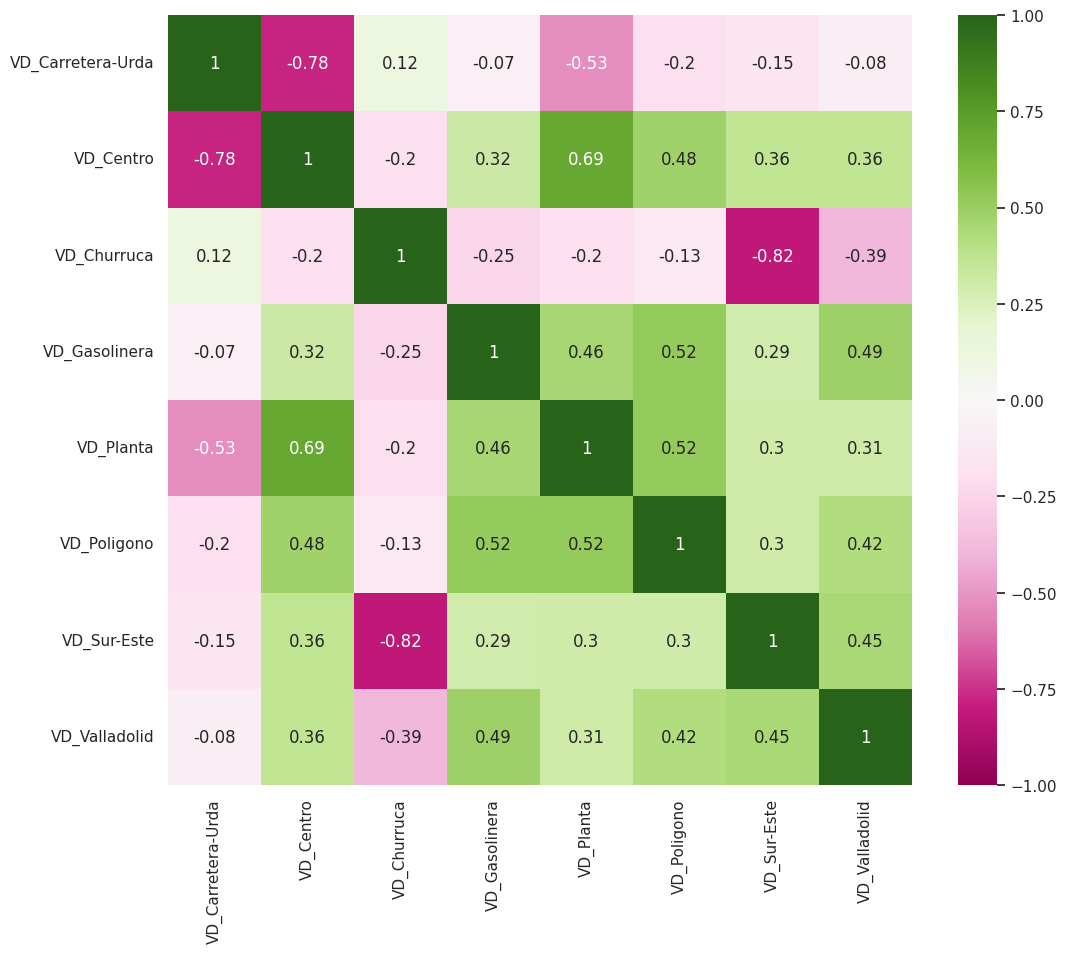

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
cols = list(range(1,9))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

<Axes: >

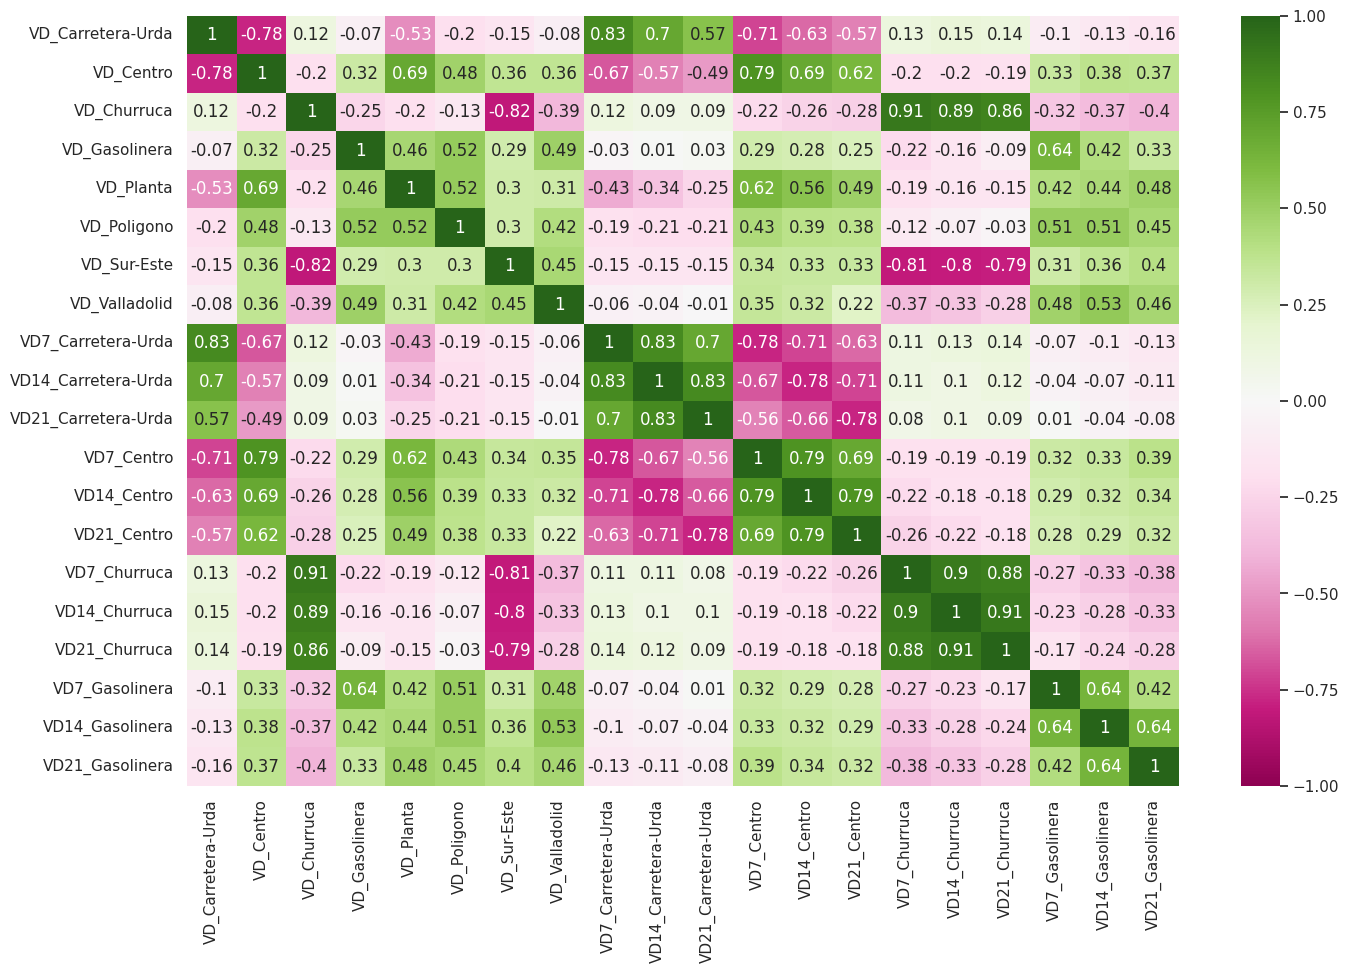

In [ ]:
sns.set(rc={'figure.figsize':(16,10)})
cols = list(range(1,9)) + list(range(31,43))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

<Axes: >

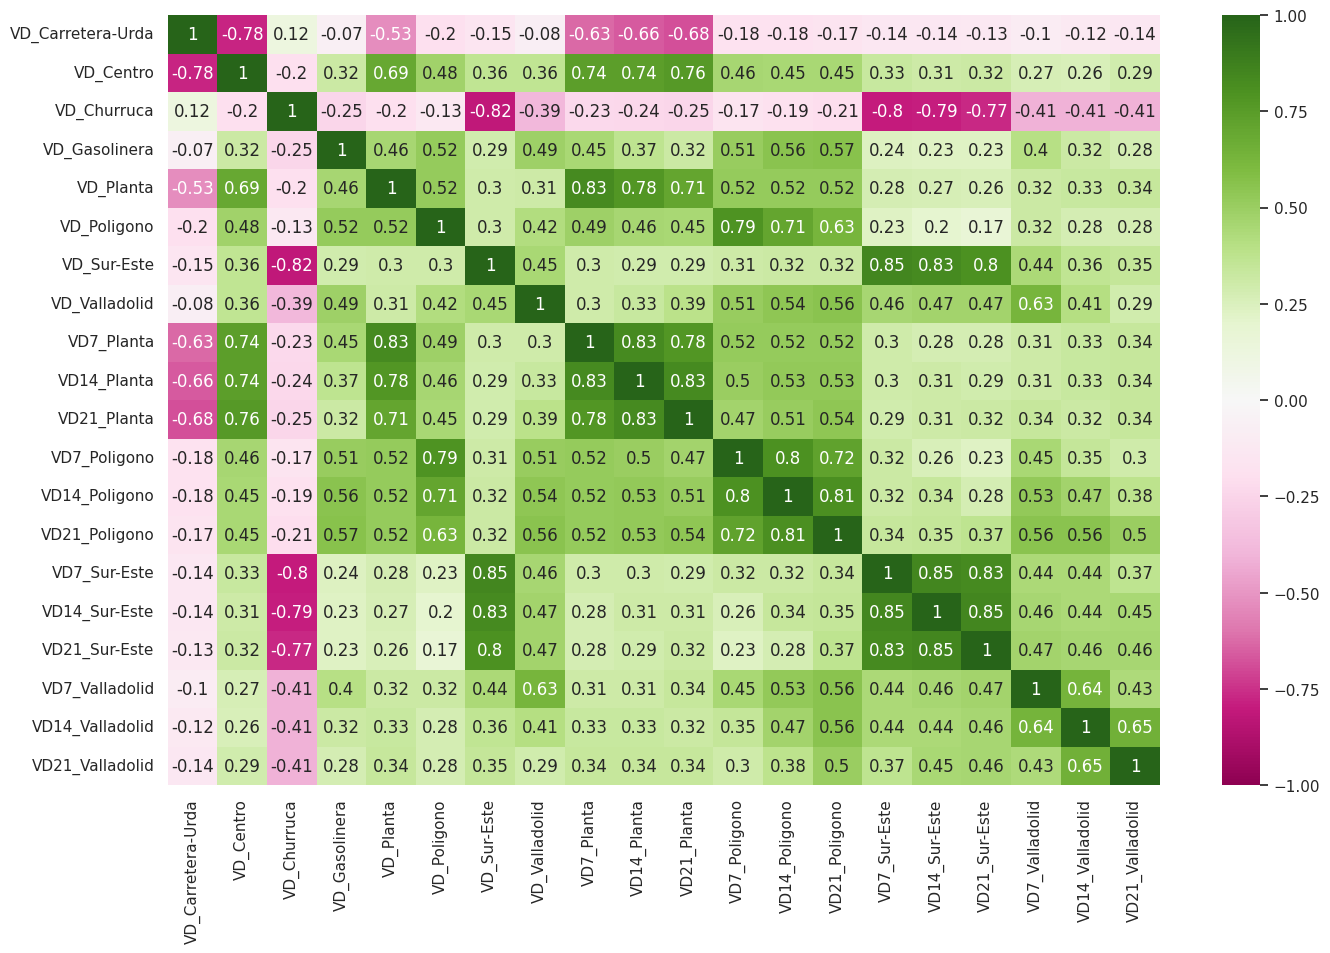

In [ ]:
sns.set(rc={'figure.figsize':(16,10)})
cols = list(range(1,9)) + list(range(43,55))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

<Axes: >

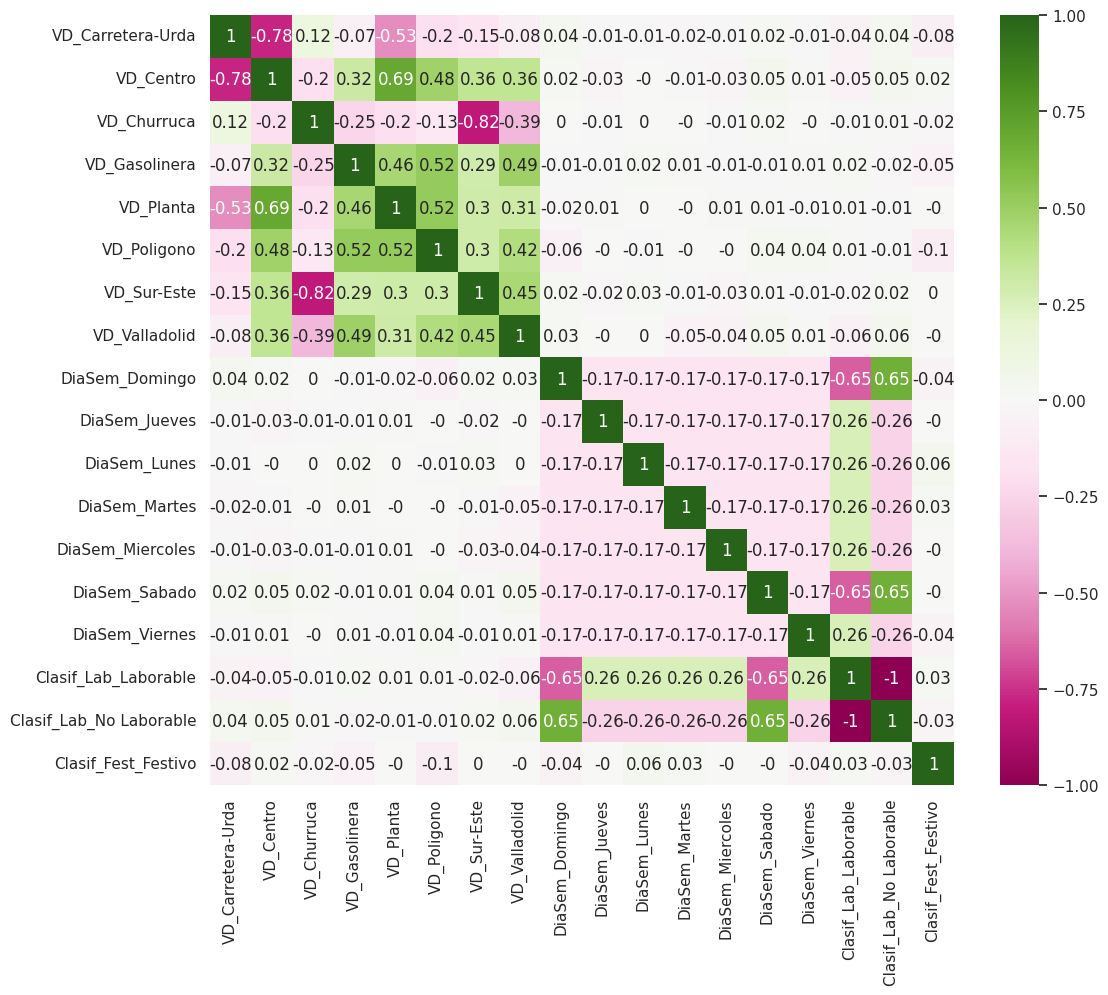

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
cols = list(range(1,9)) + list(range(9,19))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

<Axes: >

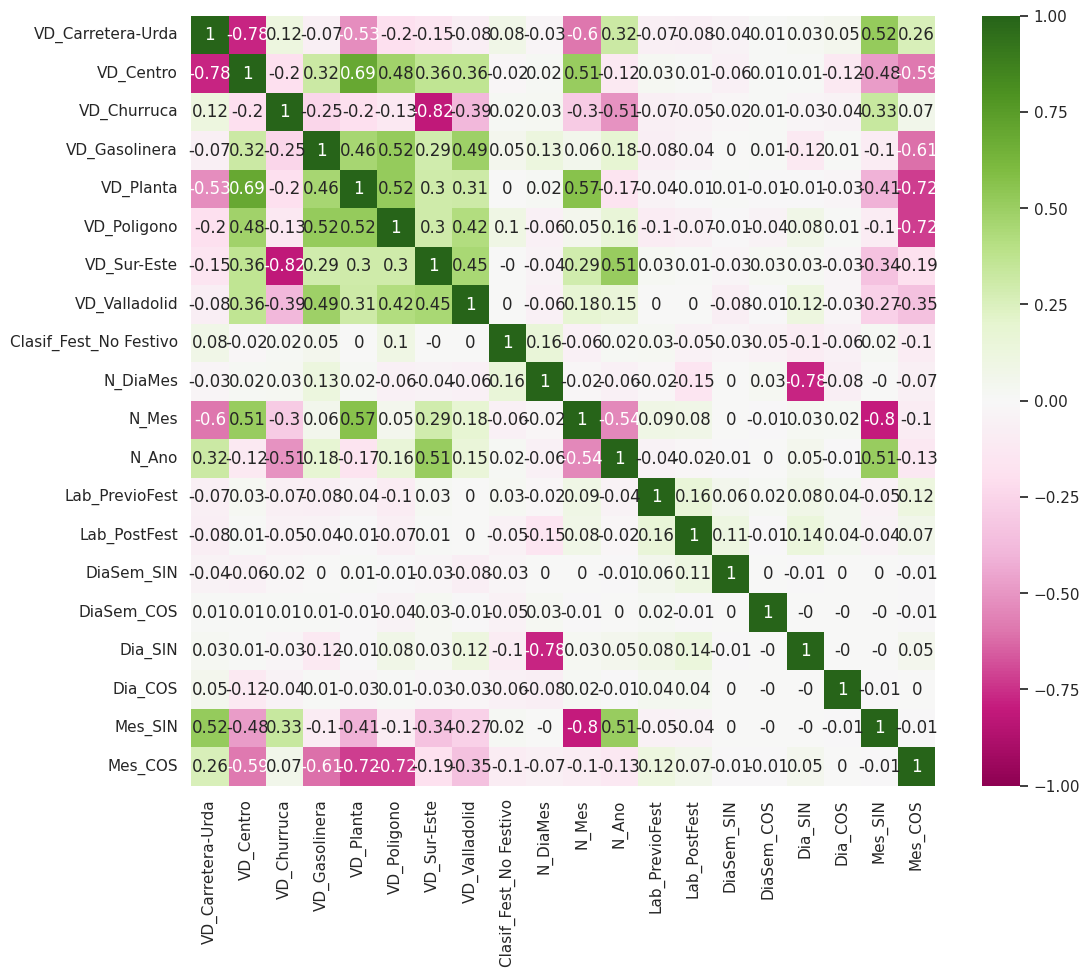

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
cols = list(range(1,9)) + list(range(19,31))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

<Axes: >

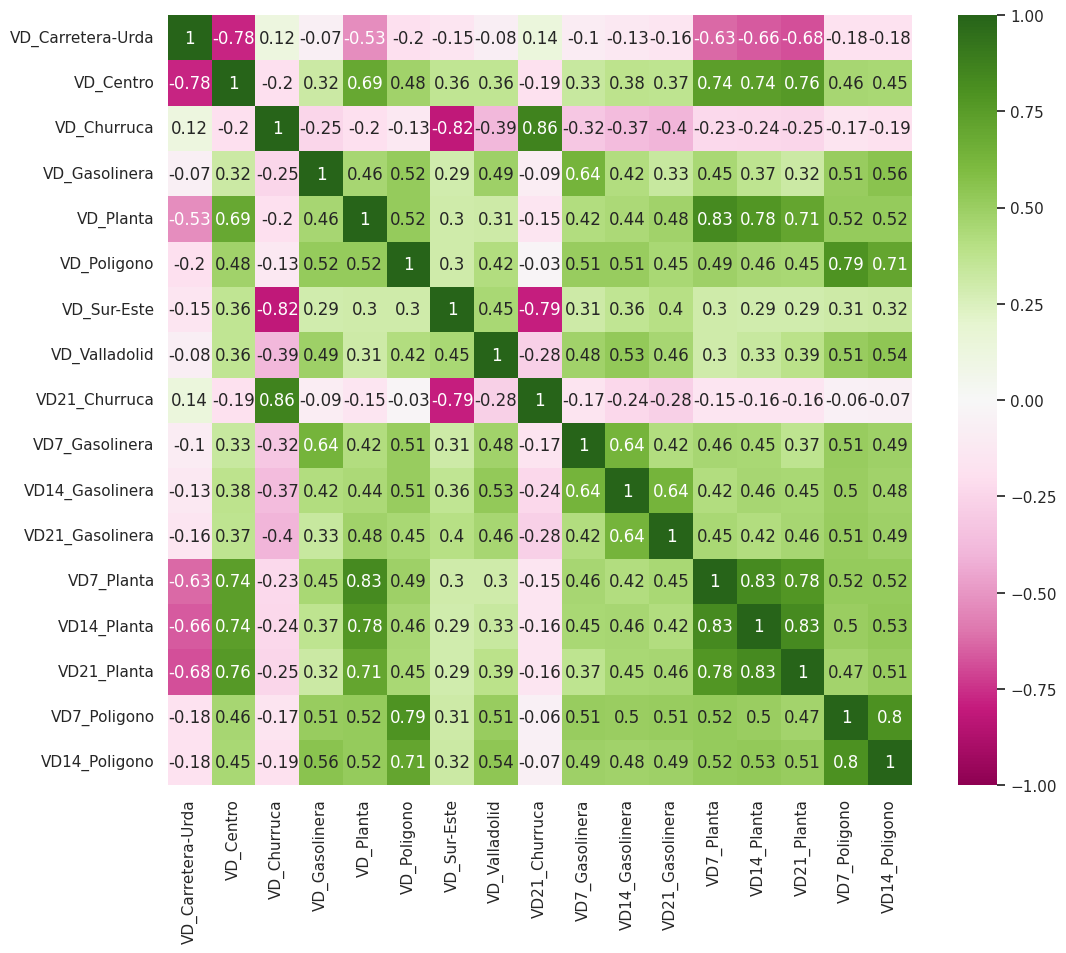

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
cols = list(range(1,9)) + list(range(39,48))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

<Axes: >

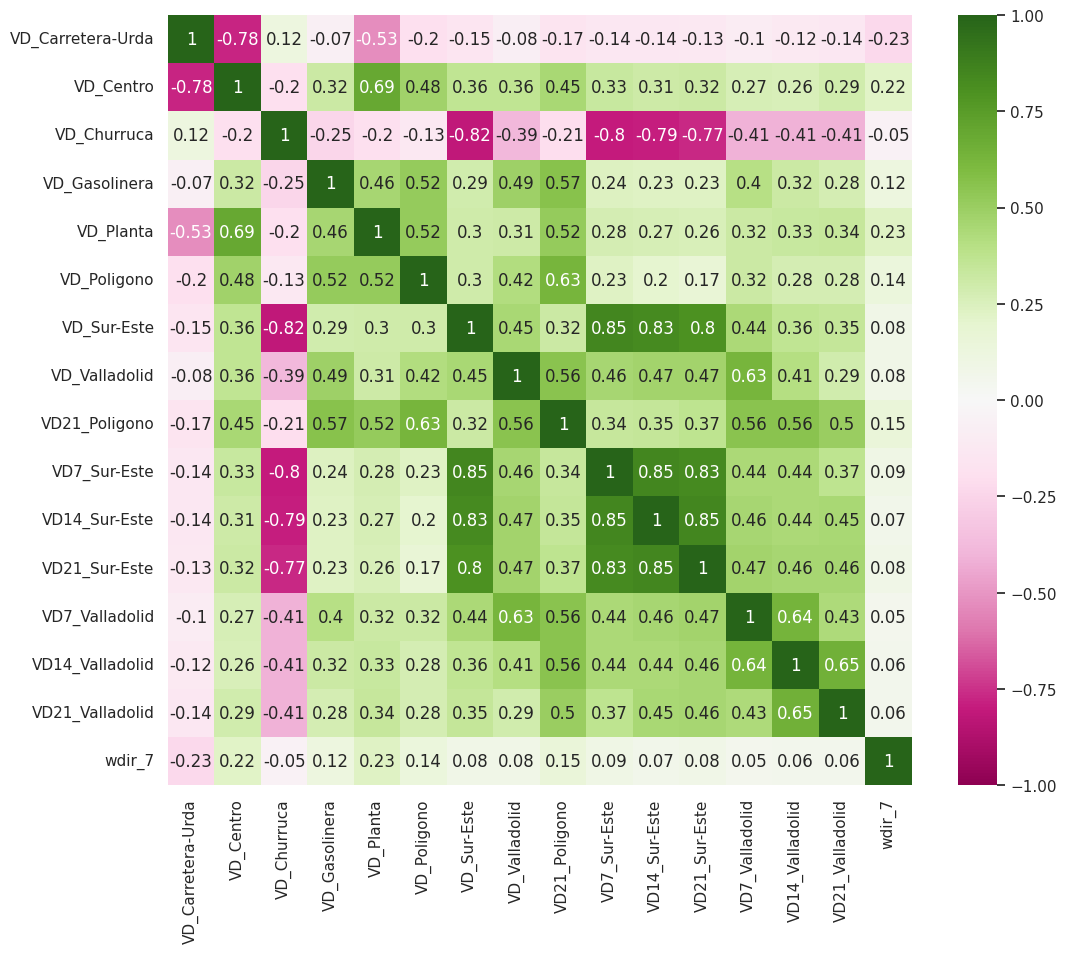

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
cols = list(range(1,9)) + list(range(48,56))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

In [ ]:
df_encshift.columns

Index(['RowKey_Date', 'VD_Carretera-Urda', 'VD_Centro', 'VD_Churruca',
       'VD_Gasolinera', 'VD_Planta', 'VD_Poligono', 'VD_Sur-Este',
       'VD_Valladolid', 'DiaSem_Domingo', 'DiaSem_Jueves', 'DiaSem_Lunes',
       'DiaSem_Martes', 'DiaSem_Miercoles', 'DiaSem_Sabado', 'DiaSem_Viernes',
       'Clasif_Lab_Laborable', 'Clasif_Lab_No Laborable',
       'Clasif_Fest_Festivo', 'Clasif_Fest_No Festivo', 'N_DiaMes', 'N_Mes',
       'N_Ano', 'Lab_PrevioFest', 'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS',
       'Dia_SIN', 'Dia_COS', 'Mes_SIN', 'Mes_COS', 'VD7_Carretera-Urda',
       'VD14_Carretera-Urda', 'VD21_Carretera-Urda', 'VD7_Centro',
       'VD14_Centro', 'VD21_Centro', 'VD7_Churruca', 'VD14_Churruca',
       'VD21_Churruca', 'VD7_Gasolinera', 'VD14_Gasolinera', 'VD21_Gasolinera',
       'VD7_Planta', 'VD14_Planta', 'VD21_Planta', 'VD7_Poligono',
       'VD14_Poligono', 'VD21_Poligono', 'VD7_Sur-Este', 'VD14_Sur-Este',
       'VD21_Sur-Este', 'VD7_Valladolid', 'VD14_Valladolid', 'VD

In [ ]:
sel_cols = ['RowKey_Date', 'VD_Carretera-Urda', 'VD_Centro', 'VD_Churruca', 'VD_Gasolinera', 'VD_Planta', 'VD_Poligono', 'VD_Sur-Este', 'VD_Valladolid',
            'VD7_Carretera-Urda', 'VD7_Centro', 'VD7_Churruca', 'VD7_Gasolinera', 'VD7_Planta', 'VD7_Poligono', 'VD7_Sur-Este', 'VD7_Valladolid',
            'wdir_7', 'temp_7', 'maxt_7', 'visibility_7', 'solarenergy_7', 'mint_7', 'solarradiation_7', 'sealevelpressure_7', 'dew_7', 'humidity_7',
            'N_Mes', 'N_Ano', 'Mes_SIN', 'Mes_COS']

In [ ]:
df_sel = df_encshift[sel_cols].copy()
df_sel

,RowKey_Date,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,VD7_Carretera-Urda,...,solarenergy_7,mint_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7,N_Mes,N_Ano,Mes_SIN,Mes_COS
0,2021-08-23,29.2300,264.3100,"1,495.0000",154.6200,447.8200,144.0900,620.8000,"1,241.6000",62.7000,...,24.9000,21.8000,493.9000,"1,015.4000",-4.7000,10.4900,8,2021,-0.5000,-0.8660
1,2021-08-24,17.6100,222.0000,"1,419.7500",146.6800,424.3700,138.3900,619.5300,"1,211.2000",65.9900,...,23.2000,20.3000,461.2000,"1,016.4000",12.5000,44.4200,8,2021,-0.5000,-0.8660
2,2021-08-25,11.6800,193.2200,"1,343.6250",145.9800,391.1800,150.6000,580.9100,"1,176.6000",54.0400,...,23.0000,17.9000,457.3000,"1,014.9000",7.8000,31.6900,8,2021,-0.5000,-0.8660
3,2021-08-26,20.7800,207.4300,"1,454.1875",148.6500,444.5700,159.1100,578.5400,"1,249.9000",70.9500,...,23.0000,18.1000,456.6000,"1,012.4000",5.9000,26.4500,8,2021,-0.5000,-0.8660
4,2021-08-27,20.4400,207.5200,"1,475.9375",149.1100,447.6500,153.3000,627.3400,"1,246.6000",56.1200,...,23.4000,17.3000,464.4000,"1,013.8000",7.0000,27.8100,8,2021,-0.5000,-0.8660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,2022-12-07,19.9900,163.5600,69.9062,99.1300,287.7900,65.6900,872.4300,"1,028.9000",19.6700,...,8.0000,-1.2000,202.6000,"1,017.5000",2.1000,77.1500,12,2022,-0.5000,0.8660
472,2022-12-08,19.8700,168.5200,49.0150,96.8300,290.7400,57.2500,861.6200,"1,046.6000",19.6500,...,9.5000,5.0000,263.4000,"1,013.0000",3.9000,72.4300,12,2022,-0.5000,0.8660
473,2022-12-09,19.7900,167.9600,69.8425,96.4000,290.3700,60.4800,874.3900,"1,053.5000",21.7300,...,9.2000,-1.0000,254.6000,"1,011.2000",3.2000,83.5200,12,2022,-0.5000,0.8660
474,2022-12-10,20.6200,178.3000,40.1800,95.5700,313.5100,62.1700,877.4800,"1,082.3000",21.6200,...,9.0000,-2.0000,250.8000,"1,007.4000",2.1000,77.4300,12,2022,-0.5000,0.8660


<ipython-input-70-5e94c926955d>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

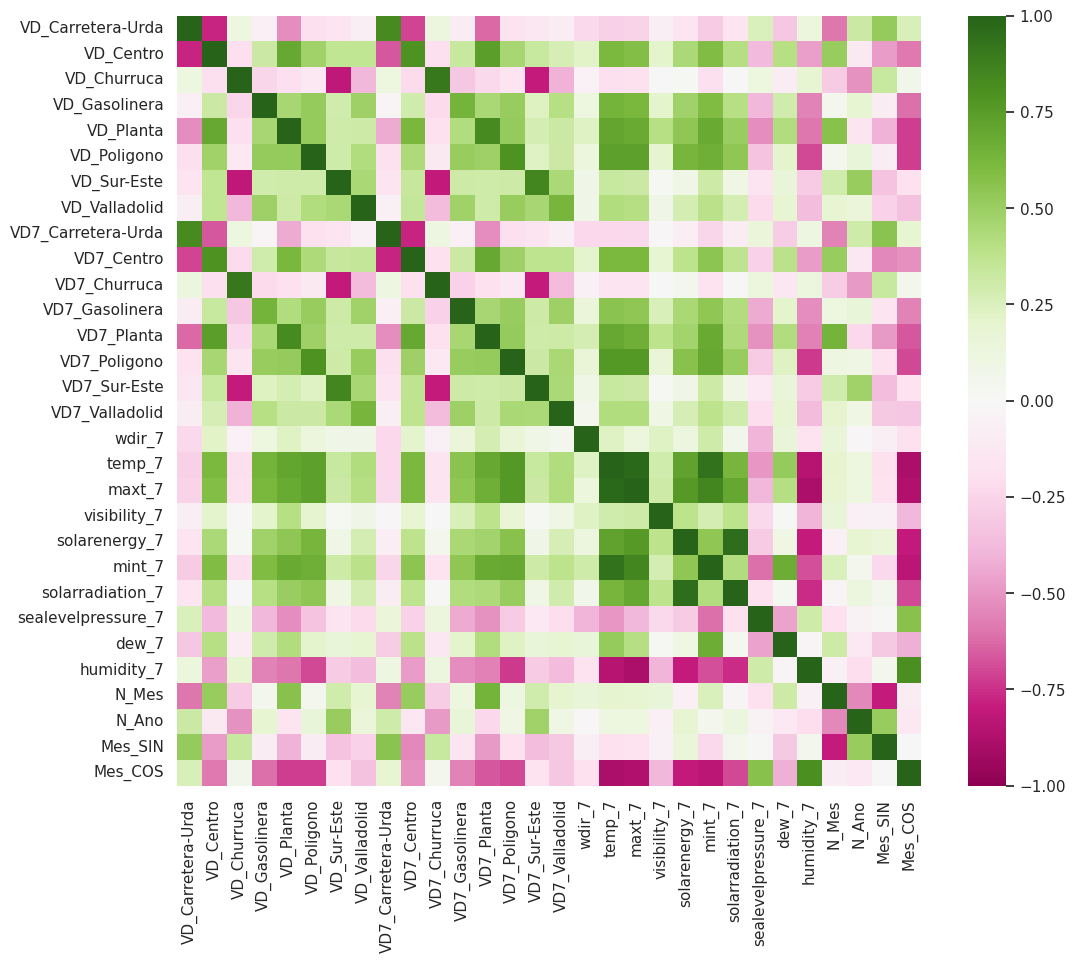

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
df_corr = df_sel.copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=False, cmap="PiYG")

## 2. ML MODEL: RANDOM FOREST

### MODEL 1 - DAILY PREDICTION

#### Target & Predictor variables

In [ ]:
df_model = df_encshift.copy()
df_model

,RowKey_Date,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,DiaSem_Domingo,...,precip_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7,precipcover_7,cond_Partially-cloudy_7,cond_Clear_7,cond_Rain_7,cond_Overcast_7
0,2021-08-23,29.2300,264.3100,"1,495.0000",154.6200,447.8200,144.0900,620.8000,"1,241.6000",0.0000,...,0.0000,493.9000,"1,015.4000",-4.7000,10.4900,0.0000,0.0000,1.0000,0.0000,0.0000
1,2021-08-24,17.6100,222.0000,"1,419.7500",146.6800,424.3700,138.3900,619.5300,"1,211.2000",0.0000,...,0.0000,461.2000,"1,016.4000",12.5000,44.4200,0.0000,0.0000,1.0000,0.0000,0.0000
2,2021-08-25,11.6800,193.2200,"1,343.6250",145.9800,391.1800,150.6000,580.9100,"1,176.6000",0.0000,...,0.0000,457.3000,"1,014.9000",7.8000,31.6900,0.0000,0.0000,1.0000,0.0000,0.0000
3,2021-08-26,20.7800,207.4300,"1,454.1875",148.6500,444.5700,159.1100,578.5400,"1,249.9000",0.0000,...,0.0000,456.6000,"1,012.4000",5.9000,26.4500,0.0000,0.0000,1.0000,0.0000,0.0000
4,2021-08-27,20.4400,207.5200,"1,475.9375",149.1100,447.6500,153.3000,627.3400,"1,246.6000",0.0000,...,0.0000,464.4000,"1,013.8000",7.0000,27.8100,0.0000,1.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,2022-12-07,19.9900,163.5600,69.9062,99.1300,287.7900,65.6900,872.4300,"1,028.9000",0.0000,...,0.0000,202.6000,"1,017.5000",2.1000,77.1500,0.0000,0.0000,1.0000,0.0000,0.0000
472,2022-12-08,19.8700,168.5200,49.0150,96.8300,290.7400,57.2500,861.6200,"1,046.6000",0.0000,...,0.0000,263.4000,"1,013.0000",3.9000,72.4300,0.0000,0.0000,1.0000,0.0000,0.0000
473,2022-12-09,19.7900,167.9600,69.8425,96.4000,290.3700,60.4800,874.3900,"1,053.5000",0.0000,...,0.0000,254.6000,"1,011.2000",3.2000,83.5200,0.0000,1.0000,0.0000,0.0000,0.0000
474,2022-12-10,20.6200,178.3000,40.1800,95.5700,313.5100,62.1700,877.4800,"1,082.3000",0.0000,...,0.0000,250.8000,"1,007.4000",2.1000,77.4300,0.0000,1.0000,0.0000,0.0000,0.0000


In [ ]:
target_cols = [x for x in list(df_model.columns) if x.startswith('VD_')]
#target_cols = list(set(target_cols) - set(untarget_cols))
target_cols

['VD_Carretera-Urda',
 'VD_Centro',
 'VD_Churruca',
 'VD_Gasolinera',
 'VD_Planta',
 'VD_Poligono',
 'VD_Sur-Este',
 'VD_Valladolid']

In [ ]:
#filter_dict = {}


In [ ]:
unselect_comvars = ['DiaSem_Domingo', 'DiaSem_Jueves', 'DiaSem_Lunes', 'DiaSem_Martes', 'DiaSem_Miercoles', 'DiaSem_Sabado', 'DiaSem_Viernes',
                    'Clasif_Lab_Laborable', 'Clasif_Lab_No Laborable', 'Clasif_Fest_Festivo', 'Clasif_Fest_No Festivo', 'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS',
                    'wdir_7', 'wspd_7', 'solarenergy_7', 'precip_7', 'solarradiation_7', 'sealevelpressure_7', 'dew_7',
                    'humidity_7', 'precipcover_7', 'cond_Partially-cloudy_7','cond_Clear_7', 'cond_Rain_7', 'cond_Overcast_7']

if len(list(filter_dict.keys())) == 0:

  filter_dict = {'VD_Carretera-Urda' : [],
                'VD_Valladolid' : [],
                'VD_Poligono' : [],
                'VD_Planta' : [],
                'VD_Centro' : [],
                'VD_Sur-Este' : [],
                'VD_Churruca' : [],
                'VD_Gasolinera' : []
                }


In [ ]:

data_cols = list(df_model.columns)
cat_vars = list(df_model.select_dtypes(exclude=["number"]).columns)
select_dict = {}

for x in target_cols:
  del_cols = list(target_cols + unselect_comvars + filter_dict[x] + cat_vars)
  select_vars = [x for x in list(df_model.columns) if x not in del_cols]
  select_dict[x] = select_vars

print(select_dict.keys())
print(select_dict[x][:10])


dict_keys(['VD_Carretera-Urda', 'VD_Centro', 'VD_Churruca', 'VD_Gasolinera', 'VD_Planta', 'VD_Poligono', 'VD_Sur-Este', 'VD_Valladolid'])
['Dia_SIN', 'VD7_Churruca', 'VD21_Churruca', 'VD7_Gasolinera', 'VD14_Gasolinera', 'VD21_Gasolinera', 'VD21_Poligono', 'VD7_Sur-Este', 'VD14_Sur-Este', 'VD21_Sur-Este']


#### Test dates

In [ ]:

start_date = dt.date(2022, 12, 1)
end_date = dt.date(2022, 12, 5)    # perhaps date.now()
delta = end_date - start_date   # returns timedelta

test_dates = []
i = 0

for x in range(delta.days + 1):
  day = start_date + dt.timedelta(days=x)
  test_dates.append(str(day))

test_dates[:5]


['2022-12-01', '2022-12-02', '2022-12-03', '2022-12-04', '2022-12-05']

#### Model definition

In [ ]:
ML_model = RandomForestRegressor()  # n_estimators=100, max_depth=6, eta=0.3

In [ ]:
train_dict = {}
test_dict = {}

for x in target_cols:

  train_dict[x] = {}
  test_dict[x] = {}

  print('\n')
  print(f'Model XGBoost (Sector "{x}")')
  print('_'*70)

  for y in test_dates:

    day = dt.datetime.strptime(y, '%Y-%m-%d')
    y7 = str(day + dt.timedelta(days=6))

    start = time.time()

    X_train = df_model[(df_model['RowKey_Date']<y)][select_dict[x]]
    y_train = df_model[(df_model['RowKey_Date']<y)][x].copy()
    y_train.reset_index(drop=True, inplace=True)
    y_train.rename("y_true", inplace=True)

    X_test = df_model[(df_model['RowKey_Date']>=y)&(df_model['RowKey_Date']<=y7)][select_dict[x]]
    y_test = df_model[(df_model['RowKey_Date']>=y)&(df_model['RowKey_Date']<=y7)][x].copy()
    y_test.reset_index(drop=True, inplace=True)
    y_test.rename("y_true", inplace=True)

    ML_model.fit(X_train, y_train)
    y_trainpred = pd.DataFrame(ML_model.predict(X_train), columns=['y_pred'])
    y_testpred = pd.DataFrame(ML_model.predict(X_test), columns=['y_pred'])

    train_res = pd.concat([y_train, y_trainpred], axis=1)
    test_res = pd.concat([y_test, y_testpred], axis=1).reset_index(drop=True)
    train_dict[x][y] = train_res
    test_dict[x][y] = test_res

    df_aux = pd.DataFrame(columns=['STA_Label','RowKey_Date'])
    #df_aux = pd.DataFrame(columns=cols)
    df_aux = pd.concat([df_aux, pd.DataFrame(ML_model.feature_importances_, index=select_dict[x]).transpose()], axis=1)
    df_aux.loc[:,'STA_Label'] = x
    df_aux.loc[:,'RowKey_Date'] = y

    if target_cols.index(x)==0 and test_dates.index(y)==0:
      imp_df = df_aux.copy()
    else:
      imp_df = pd.concat([imp_df, df_aux], axis=0)
      #imp_df = pd.concat([imp_df, df_aux], axis=0)
      imp_df.reset_index(drop=True,inplace=True)
      imp_df

    end = time.time()
    #print('_'*35)
    print(f'-Test {y} ({timedelta(minutes=end-start)}))')
    #print('\n')




Model XGBoost (Sector "VD_Carretera-Urda")
______________________________________________________________________
-Test 2022-12-01 (0:00:35.183501))
-Test 2022-12-02 (0:00:35.609121))
-Test 2022-12-03 (0:00:35.199995))
-Test 2022-12-04 (0:00:36.030421))
-Test 2022-12-05 (0:00:35.689144))


Model XGBoost (Sector "VD_Centro")
______________________________________________________________________
-Test 2022-12-01 (0:00:46.819782))
-Test 2022-12-02 (0:00:33.797965))
-Test 2022-12-03 (0:00:29.588213))
-Test 2022-12-04 (0:00:29.845634))
-Test 2022-12-05 (0:00:29.578886))


Model XGBoost (Sector "VD_Churruca")
______________________________________________________________________
-Test 2022-12-01 (0:00:22.653351))
-Test 2022-12-02 (0:00:22.931972))
-Test 2022-12-03 (0:00:22.443209))
-Test 2022-12-04 (0:00:23.163829))
-Test 2022-12-05 (0:00:22.527280))


Model XGBoost (Sector "VD_Gasolinera")
______________________________________________________________________
-Test 2022-12-01 (0:00:31.219

#### Feature importance

In [ ]:
cols = ['STA_Label'] + [x for x in list(df_model.columns) if x in list(imp_df.columns)]
imp_df = imp_df[cols]
imp_df

,STA_Label,RowKey_Date,N_DiaMes,N_Mes,Dia_SIN,Dia_COS,Mes_COS,VD7_Carretera-Urda,VD14_Carretera-Urda,VD21_Carretera-Urda,...,VD7_Sur-Este,VD14_Sur-Este,VD21_Sur-Este,VD7_Valladolid,VD14_Valladolid,VD21_Valladolid,temp_7,maxt_7,visibility_7,mint_7
0,VD_Carretera-Urda,2022-12-01,NaN,NaN,NaN,0.0269,NaN,0.7049,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0293,NaN,NaN,0.0643
1,VD_Carretera-Urda,2022-12-02,NaN,NaN,NaN,0.0301,NaN,0.7277,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0302,NaN,NaN,0.0682
2,VD_Carretera-Urda,2022-12-03,NaN,NaN,NaN,0.0230,NaN,0.6791,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0294,NaN,NaN,0.0691
3,VD_Carretera-Urda,2022-12-04,NaN,NaN,NaN,0.0276,NaN,0.6848,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0294,NaN,NaN,0.0706
4,VD_Carretera-Urda,2022-12-05,NaN,NaN,NaN,0.0250,NaN,0.6796,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0285,NaN,NaN,0.0704
5,VD_Centro,2022-12-01,NaN,0.1045,NaN,NaN,0.0325,0.2541,NaN,NaN,...,NaN,NaN,0.0244,NaN,NaN,NaN,0.0421,0.0385,NaN,NaN
6,VD_Centro,2022-12-02,NaN,0.0783,NaN,NaN,0.0349,0.2914,NaN,NaN,...,NaN,NaN,0.0245,NaN,NaN,NaN,0.0465,0.0345,NaN,NaN
7,VD_Centro,2022-12-03,NaN,0.0788,NaN,NaN,0.0342,0.2298,NaN,NaN,...,NaN,NaN,0.0213,NaN,NaN,NaN,0.0434,0.0386,NaN,NaN
8,VD_Centro,2022-12-04,NaN,0.0772,NaN,NaN,0.0322,0.3241,NaN,NaN,...,NaN,NaN,0.0257,NaN,NaN,NaN,0.0518,0.0463,NaN,NaN
9,VD_Centro,2022-12-05,NaN,0.0705,NaN,NaN,0.0349,0.2861,NaN,NaN,...,NaN,NaN,0.0276,NaN,NaN,NaN,0.0395,0.0443,NaN,NaN


In [ ]:
imp_df.iloc[:,range(0,16)].groupby('STA_Label').mean()

<ipython-input-186-5822dc9c7b23>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,N_DiaMes,N_Mes,Dia_SIN,Dia_COS,Mes_COS,VD7_Carretera-Urda,VD14_Carretera-Urda,VD21_Carretera-Urda,VD7_Centro,VD14_Centro,VD21_Centro,VD7_Churruca,VD14_Churruca,VD21_Churruca
STA_Label,,,,,,,,,,,,,,
VD_Carretera-Urda,NaN,NaN,NaN,0.0265,NaN,0.6952,NaN,NaN,0.0197,0.0284,NaN,0.0261,NaN,NaN
VD_Centro,NaN,0.0818,NaN,NaN,0.0337,0.2771,NaN,NaN,0.0692,0.0602,0.0204,NaN,0.0243,NaN
VD_Churruca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3098,0.0448,0.0177
VD_Gasolinera,NaN,NaN,NaN,NaN,0.0541,0.0154,0.0142,0.0132,NaN,NaN,NaN,NaN,NaN,0.0176
VD_Planta,NaN,0.6803,NaN,NaN,0.0154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VD_Poligono,0.0295,NaN,NaN,0.0156,0.3091,NaN,0.0269,NaN,NaN,NaN,NaN,0.0194,0.0169,NaN
VD_Sur-Este,0.0187,0.0281,NaN,NaN,0.0678,NaN,NaN,0.0216,NaN,NaN,NaN,0.2987,0.0980,NaN
VD_Valladolid,NaN,NaN,0.0224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0501,NaN,0.0168


In [ ]:
imp_df.iloc[:,list(range(0,2))+list(range(16,27))].groupby('STA_Label').mean()

<ipython-input-187-6f11acf05eaa>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,VD7_Gasolinera,VD14_Gasolinera,VD21_Gasolinera,VD7_Planta,VD14_Planta,VD21_Planta,VD7_Poligono,VD14_Poligono,VD21_Poligono,VD7_Sur-Este,VD14_Sur-Este
STA_Label,,,,,,,,,,,
VD_Carretera-Urda,NaN,NaN,NaN,0.1062,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VD_Centro,NaN,0.0244,NaN,0.1652,0.0264,0.1074,NaN,NaN,NaN,NaN,NaN
VD_Churruca,0.0213,0.0244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2068,0.3443
VD_Gasolinera,0.5334,0.0213,0.0552,NaN,NaN,NaN,0.0161,NaN,0.0310,NaN,0.0218
VD_Planta,0.0376,0.0272,NaN,0.0488,NaN,NaN,NaN,NaN,0.0416,NaN,NaN
VD_Poligono,0.0185,0.0198,NaN,NaN,NaN,NaN,0.2816,0.0188,0.0339,NaN,NaN
VD_Sur-Este,0.0387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2882,0.0881
VD_Valladolid,0.0293,0.0714,0.1491,NaN,NaN,NaN,NaN,NaN,0.0204,0.0250,0.0222


In [ ]:
#imp_df.iloc[:,list(range(0,2))+list(range(27,37))].groupby('STA_Label').mean()

In [ ]:
prevfilter_dict = filter_dict.copy()

In [ ]:
filter_dict = {}
impgroup_df = imp_df.groupby('STA_Label').mean()
#impgroup_df.reset_index(drop=True, inplace=True)

for x in target_cols:
  filter_vars = []

  for y in list(impgroup_df.columns):
    imp_value = impgroup_df.loc[x,y]

    if imp_value < 0.01:
      filter_vars.append(y)

  filter_dict[x] = filter_vars


<ipython-input-190-c10e59936cee>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [ ]:
filter_dict

{'VD_Carretera-Urda': [],
 'VD_Centro': [],
 'VD_Churruca': [],
 'VD_Gasolinera': [],
 'VD_Planta': [],
 'VD_Poligono': [],
 'VD_Sur-Este': [],
 'VD_Valladolid': []}

#### Train/Test scores

In [ ]:
train_dict.keys()

dict_keys(['VD_Carretera-Urda', 'VD_Centro', 'VD_Churruca', 'VD_Gasolinera', 'VD_Planta', 'VD_Poligono', 'VD_Sur-Este', 'VD_Valladolid'])

In [ ]:
train_dict['VD_Carretera-Urda']['2022-12-05']

,y_true,y_pred
0,29.2300,33.8390
1,17.6100,23.0084
2,11.6800,18.9588
3,20.7800,23.1000
4,20.4400,24.0647
...,...,...
464,19.6700,18.8449
465,19.6500,19.0281
466,21.7300,20.3051
467,21.6200,21.2875


In [ ]:
test_dict.keys()

dict_keys(['VD_Carretera-Urda', 'VD_Centro', 'VD_Churruca', 'VD_Gasolinera', 'VD_Planta', 'VD_Poligono', 'VD_Sur-Este', 'VD_Valladolid'])

In [ ]:
test_dict['VD_Carretera-Urda']['2022-12-05']

,y_true,y_pred
0,19.5200,17.2677
1,23.3400,17.5752
2,19.9900,15.6692
3,19.8700,19.4238
4,19.7900,20.7444
5,20.6200,20.8661
6,21.3800,18.3443


In [ ]:
target_cols[:5]

['VD_Carretera-Urda', 'VD_Centro', 'VD_Churruca', 'VD_Gasolinera', 'VD_Planta']

In [ ]:
test_dates[:5]

['2022-12-01', '2022-12-02', '2022-12-03', '2022-12-04', '2022-12-05']

In [ ]:

df_scores = pd.DataFrame(columns=['STA_Label','RowKey_Date','Train_MAPE','Train_MAE','Train_RMSE','Test_MAPE','Test_MAE','Test_RMSE'])
i = 0

for x in target_cols:
  for y in test_dates:

    df_scores.loc[i,'STA_Label'] = x
    df_scores.loc[i,'RowKey_Date'] = y

    # TRAIN SCORES
    y_true = train_dict[x][y].iloc[:,0]
    y_pred = train_dict[x][y].iloc[:,1]
    #mape = round(mean_absolute_percentage_error(y_true, y_pred), 4)
    mape = round(mape_corr(y_true, y_pred), 4)
    mae = round(mean_absolute_error(y_true, y_pred), 4)
    rmse = round(mean_squared_error(y_true, y_pred, squared=False), 4)

    df_scores.loc[i,'Train_MAPE'] = mape
    df_scores.loc[i,'Train_MAE'] = mae
    df_scores.loc[i,'Train_RMSE'] = rmse

    # TEST SCORES
    y_true = test_dict[x][y].iloc[:,0]
    y_pred = test_dict[x][y].iloc[:,1]
    #mape = round(mean_absolute_percentage_error(y_true, y_pred), 4)
    mape = round(mape_corr(y_true, y_pred), 4)
    mae = round(mean_absolute_error(y_true, y_pred), 4)
    rmse = round(mean_squared_error(y_true, y_pred, squared=False), 4)

    df_scores.loc[i,'Test_MAPE'] = mape
    df_scores.loc[i,'Test_MAE'] = mae
    df_scores.loc[i,'Test_RMSE'] = rmse

    i += 1


In [ ]:
df_scores

,STA_Label,RowKey_Date,Train_MAPE,Train_MAE,Train_RMSE,Test_MAPE,Test_MAE,Test_RMSE
0,VD_Carretera-Urda,2022-12-01,0.2700,3.2931,6.1875,0.1302,2.7517,2.9092
1,VD_Carretera-Urda,2022-12-02,0.2425,3.2052,5.8531,0.1103,2.3739,2.7448
2,VD_Carretera-Urda,2022-12-03,0.2294,3.2119,5.6531,0.0484,0.9918,1.4630
3,VD_Carretera-Urda,2022-12-04,0.2859,3.2100,5.9559,0.0798,1.6495,2.0488
4,VD_Carretera-Urda,2022-12-05,0.2274,3.2332,6.1319,0.1147,2.4315,3.1021
5,VD_Centro,2022-12-01,0,5.3673,10.3984,0.0351,6.0125,6.7945
6,VD_Centro,2022-12-02,0,5.2627,10.7064,0.0421,7.2380,7.8721
7,VD_Centro,2022-12-03,0,5.3697,10.6873,0.0353,6.0511,6.9496
8,VD_Centro,2022-12-04,0,5.4420,10.3797,0.0296,5.0371,6.6051
9,VD_Centro,2022-12-05,0,5.2367,10.2753,0.0302,5.1648,6.2092


In [ ]:
final_scores = df_scores.groupby('STA_Label').mean().reset_index()
final_scores

<ipython-input-200-99a6e135f461>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,STA_Label,Train_MAPE,Train_MAE,Train_RMSE,Test_MAPE,Test_MAE,Test_RMSE
0,VD_Carretera-Urda,0.2510,3.2307,5.9563,0.0967,2.0397,2.4536
1,VD_Centro,0.0000,5.3357,10.4894,0.0345,5.9007,6.8861
2,VD_Churruca,0.0000,30.3669,62.0251,2.9410,48.5470,67.0790
3,VD_Gasolinera,0.0000,5.8324,11.6790,0.0341,3.4003,4.3637
4,VD_Planta,0.0000,11.3233,21.2025,0.2106,62.0355,83.2357
5,VD_Poligono,0.0573,5.0651,6.9835,0.1195,7.4041,9.6862
6,VD_Sur-Este,0.0662,11.8317,23.7125,0.0558,48.5805,65.3915
7,VD_Valladolid,0.0000,27.8974,57.0476,0.0872,90.9059,105.3017


In [ ]:
df_model.iloc[:,range(0,9)].describe()

,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid
count,476.0000,476.0000,476.0000,476.0000,476.0000,476.0000,476.0000,476.0000
mean,46.7641,165.1896,808.7730,144.9077,286.4416,94.7016,641.0988,887.4518
std,62.5463,81.1981,531.6525,85.5647,153.4498,44.5832,158.2979,308.6592
min,0.1300,0.0000,0.0000,0.0000,0.0000,40.0400,11.9700,0.0000
25%,10.1225,152.9568,51.0487,85.8325,275.6925,60.0975,526.3525,738.5750
50%,20.5250,192.0800,"1,029.7500",129.6550,334.8100,77.9450,581.0350,816.5000
75%,40.8350,218.9875,"1,170.2106",169.6725,388.0675,124.6650,773.7625,"1,144.2000"
max,217.0700,292.3800,"1,579.9375",585.9800,518.2600,213.9900,973.5500,"1,528.4000"


In [ ]:

for x in target_cols:
  for y in test_dates:

    df_train = train_dict[x][y]
    df_test = test_dict[x][y]

    if target_cols.index(x)==0 and test_dates.index(y)==0:
      preds_train = pd.DataFrame(columns=['y_true','y_pred'])
      preds_test = pd.DataFrame(columns=['y_true','y_pred'])
    else:
      preds_train = pd.concat([preds_train, df_train], axis=0)
      preds_train.reset_index(drop=True,inplace=True)

      preds_test = pd.concat([preds_test, df_test], axis=0)
      preds_test.reset_index(drop=True,inplace=True)


In [ ]:
preds_train

,y_true,y_pred
0,29.2300,33.8405
1,17.6100,21.7918
2,11.6800,16.7620
3,20.7800,23.0722
4,20.4400,24.3056
...,...,...
18210,997.9000,958.6470
18211,"1,017.5000","1,040.5760"
18212,"1,021.1000",991.3790
18213,"1,093.8000","1,093.2120"


In [ ]:
preds_test

,y_true,y_pred
0,21.7300,18.4032
1,21.6200,20.2565
2,21.7900,19.1455
3,19.5200,18.2601
4,23.3400,18.9638
...,...,...
268,"1,028.9000",872.9770
269,"1,046.6000",901.9190
270,"1,053.5000",892.3250
271,"1,082.3000","1,065.1760"


In [ ]:
preds_test[preds_test['y_pred']<0]

,y_true,y_pred


In [ ]:
df = pd.DataFrame(preds_test['y_true']-preds_test['y_pred'])
df

,0
0,3.3268
1,1.3635
2,2.6445
3,1.2599
4,4.3762
...,...
268,155.9230
269,144.6810
270,161.1750
271,17.1240


In [ ]:
df[df[0]<-50]

,0
63,-126.7732
64,-118.4839
65,-58.5211
69,-246.1072
70,-97.3294
75,-185.7920
81,-60.6096
87,-146.1132
90,-79.3450
93,-84.4562


In [ ]:
df[df[0]>200]

,0


In [ ]:
Train_MAPE = mape_corr(preds_train['y_true'], preds_train['y_pred'])*100
Train_MAE = mean_absolute_error(preds_train['y_true'], preds_train['y_pred'])
Train_RMSE = mean_squared_error(preds_train['y_true'], preds_train['y_pred'], squared=False)

Test_MAPE = mape_corr(preds_test['y_true'], preds_test['y_pred'])*100
Test_MAE = mean_absolute_error(preds_test['y_true'], preds_test['y_pred'])
Test_RMSE = mean_squared_error(preds_test['y_true'], preds_test['y_pred'], squared=False)

#### Results

In [ ]:
print('Train scores: 3')
print(f'MAPE = {Train_MAPE:.4f} %')
print(f'MAE = {Train_MAE:.4f}')
print(f'RMSE = {Train_RMSE:.4f}')

print('Test scores:')
print(f'MAPE = {Test_MAPE:.4f} %')
print(f'MAE = {Test_MAE:.4f}')
print(f'RMSE = {Test_RMSE:.4f}')

Train scores: 3
MAPE = 0.0000 %
MAE = 12.8484
RMSE = 32.9004
Test scores:
MAPE = 45.5568 %
MAE = 34.3927
RMSE = 60.6082
